In [5]:
# ----------------------------
# 1. Environment Setup
# ----------------------------
!pip install qiskit==1.4.2 qiskit_finance qiskit_aer pylatexenc
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import NormalDistribution

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.9/645.9 kB 23.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [60]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
import numpy as np
from scipy.stats import norm
from qiskit.circuit.library import LinearAmplitudeFunction

class PiecewiseLinearDistribution(QuantumCircuit):
    """
    Quantum circuit implementing a piecewise linear approximation of asset returns distribution.
    This provides better modeling of non-normal asset returns with fat tails and skewness.
    """
    def __init__(self, num_qubits, breakpoints, slopes, offsets, bounds=None):
        """
        Args:
            num_qubits (int): Number of qubits to represent the distribution
            breakpoints (list): List of x coordinates for breakpoints in the piecewise function
            slopes (list): List of slopes for each linear segment
            offsets (list): List of offsets for each linear segment
            bounds (tuple): Minimum and maximum values for the range to represent
        """
        super().__init__(num_qubits, name="PiecewiseLinear")
        
        # If no bounds provided, determine from breakpoints
        if bounds is None:
            min_val = min(breakpoints) - 1.0
            max_val = max(breakpoints) + 1.0
            bounds = (min_val, max_val)
        
        # Convert breakpoints to normalized values in [0,1]
        range_size = bounds[1] - bounds[0]
        norm_breakpoints = [(x - bounds[0]) / range_size for x in breakpoints]
        
        # Create piecewise linear function for amplitude encoding
        linear_function = LinearAmplitudeFunction(
            num_qubits=num_qubits,
            breakpoints=norm_breakpoints,
            slopes=slopes,
            offsets=offsets
        )
        
        # Compose the linear function into this circuit
        self.compose(linear_function, inplace=True)


class QuantumCopula(QuantumCircuit):
    """
    Implements a quantum version of a copula for modeling asset dependencies.
    Uses Gaussian copula as the underlying model but can be extended to other types.
    """
    def __init__(self, asset_qregs, correlation_matrix):
        """
        Args:
            asset_qregs (list): List of quantum registers for each asset
            correlation_matrix (ndarray): Correlation matrix between assets
        """
        super().__init__(*asset_qregs, name="QuantumCopula")
        
        self.num_assets = len(asset_qregs)
        self.correlation_matrix = correlation_matrix
        
        # Apply copula transformations
        self._apply_gaussian_copula()
    
    def _apply_gaussian_copula(self):
        """Apply quantum operations to implement a Gaussian copula structure"""
        # Implement Gaussian copula using controlled rotations
        for i in range(self.num_assets):
            for j in range(i+1, self.num_assets):
                corr = self.correlation_matrix[i, j]
                if abs(corr) > 0.01:  # Only consider significant correlations
                    # Calculate rotation angle based on correlation
                    # For Gaussian copula, we use arcsin of correlation as angle
                    theta = np.arcsin(corr) 
                    
                    # Apply controlled rotation to create correlation
                    for q_i in range(len(self.qubits[i])):
                        for q_j in range(len(self.qubits[j])):
                            # Apply controlled rotation with the correlation angle
                            self.cry(theta, self.qubits[i][q_i], self.qubits[j][q_j])
                            
                    # For negative correlation, add a phase flip
                    if corr < 0:
                        for q in range(len(self.qubits[j])):
                            self.z(self.qubits[j][q])


In [61]:
class AssetDistributionCircuit(QuantumCircuit):
    """Enhanced quantum circuit for asset returns distribution with piecewise linear approximation and copula"""
    def __init__(self, returns_array, correlation_matrix, num_qubits=NUM_QUBITS_PER_ASSET):
        self.num_assets = len(returns_array)
        self.asset_qregs = [QuantumRegister(num_qubits, f'asset_{i}') for i in range(self.num_assets)]
        self.objective_qreg = QuantumRegister(1, 'objective')

        # Initialize circuit with all registers
        super().__init__(*self.asset_qregs, self.objective_qreg, name="AssetDistribution")

        # Store returns array for piecewise approximation
        self.returns_array = returns_array
        self.correlation_matrix = correlation_matrix
        
        # Calculate statistics for each asset
        self.mu_values = [np.mean(returns_array[i]) for i in range(self.num_assets)]
        self.sigma_values = [np.std(returns_array[i]) for i in range(self.num_assets)]

        # Build the circuit
        self._create_piecewise_asset_distributions()
        self._add_copula_dependencies()

    def _create_piecewise_asset_distributions(self):
        """Create piecewise linear distributions for each asset based on empirical data"""
        for i in range(self.num_assets):
            # Get returns data for this asset
            asset_returns = self.returns_array[i]
            
            # Generate empirical CDF breakpoints (using quantiles)
            num_segments = 2**len(self.asset_qregs[i]) - 1
            quantiles = np.linspace(0.1, 0.9, num_segments)
            breakpoints = np.quantile(asset_returns, quantiles)
            
            # Calculate bounds with padding
            min_val = min(asset_returns) - 0.5 * self.sigma_values[i]
            max_val = max(asset_returns) + 0.5 * self.sigma_values[i]
            bounds = (min_val, max_val)
            
            # Create slopes and offsets based on empirical PDF
            # This is a simple approximation - could be more sophisticated
            hist, bin_edges = np.histogram(asset_returns, bins=num_segments+1, 
                                          range=bounds, density=True)
            
            # Convert histogram to slopes and offsets
            slopes = []
            offsets = []
            
            for j in range(len(hist)):
                if j < len(hist) - 1:
                    slope = (hist[j+1] - hist[j]) / (bin_edges[j+1] - bin_edges[j])
                else:
                    slope = 0
                slopes.append(slope)
                offsets.append(hist[j])
            
            # Create piecewise linear distribution circuit
            piecewise_dist = PiecewiseLinearDistribution(
                num_qubits=len(self.asset_qregs[i]),
                breakpoints=bin_edges[:-1],  # Exclude the last edge
                slopes=slopes,
                offsets=offsets,
                bounds=bounds
            )
            
            self.compose(piecewise_dist, self.asset_qregs[i], inplace=True)

    def _add_copula_dependencies(self):
        """Add copula-based correlation between assets"""
        # Create quantum copula circuit
        copula = QuantumCopula(self.asset_qregs, self.correlation_matrix)
        
        # Add copula circuit to main circuit
        self.compose(copula, self.asset_qregs, inplace=True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools
import re
from scipy import stats
from scipy.stats import norm

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library import GroverOperator
from qiskit.visualization import circuit_drawer

# Constants
CONFIDENCE_LEVELS = [0.95, 0.99]  # Multiple confidence levels
EPSILON = 0.01  # Target accuracy for amplitude estimation
ALPHA = 0.01    # Confidence for estimation
NUM_QUBITS_PER_ASSET = 2  # Number of qubits for each asset's distribution

# =============== DATA LOADING MODULE =============== #

def read_asset_data(path):
    """Read asset data from CSV file."""
    asset = pd.read_csv(path, delimiter='\t', usecols=[0, 4], names=['datetime', 'price'])
    asset.datetime = pd.to_datetime(asset.datetime)
    asset.set_index('datetime', inplace=True)
    asset_name = "".join(re.findall("[a-zA-Z]+", path))[-9:-3]
    asset.rename(columns={"price": asset_name}, inplace=True)
    return asset[[asset_name]]

def load_asset_data(paths):
    """Load multiple asset data files and combine them."""
    assets = {}
    for i, path in enumerate(paths):
        assets[f"asset{i}"] = read_asset_data(path)

    prices = pd.concat(assets.values(), axis=1)
    prices.columns = [path.split('/')[-1].split('.')[0] for path in paths]
    prices = prices.dropna()
    return prices

def prepare_returns_data(prices, start_date='2015-01-01'):
    """Calculate returns from price data."""
    returns = prices.pct_change().dropna()
    returns = returns.asfreq('D', fill_value=0.0)  # Ensure daily frequency
    returns = returns[returns.index >= start_date]
    return returns

def get_returns_and_correlation(returns_df, asset_combination=None):
    """Extract returns array and correlation matrix for selected assets."""
    if asset_combination is None:
        selected_returns = returns_df
    else:
        selected_returns = returns_df[list(asset_combination)]

    returns_array = selected_returns.values.T
    correlation_matrix = np.corrcoef(returns_array)
    return returns_array, correlation_matrix, selected_returns

# =============== VAR CALCULATION MODULE =============== #

def calculate_historical_var(returns_array, weights, confidence_level=0.99):
    """Calculate VaR using historical simulation method."""
    portfolio_returns = np.dot(weights, returns_array)
    var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    return var, portfolio_returns

# This is the original calculate_vc_var renamed for clarity
def calculate_parametric_var(returns_array, weights, confidence_level=0.99):
    """Calculate VaR using parametric (variance-covariance) method."""
    portfolio_returns = np.dot(weights, returns_array)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    z_score = stats.norm.ppf(confidence_level)
    var = (portfolio_mean + z_score * portfolio_std)
    return var, portfolio_returns

# Keep AssetDistributionCircuit
class AssetDistributionCircuit(QuantumCircuit):
    """Quantum circuit for asset returns distribution with correlation"""
    def __init__(self, returns_array, correlation_matrix, num_qubits=NUM_QUBITS_PER_ASSET):
        self.num_assets = len(returns_array)
        self.asset_qregs = [QuantumRegister(num_qubits, f'asset_{i}') for i in range(self.num_assets)]
        self.objective_qreg = QuantumRegister(1, 'objective')

        # Initialize circuit with all registers
        super().__init__(*self.asset_qregs, self.objective_qreg, name="AssetDistribution")

        # Calculate statistics for each asset
        self.mu_values = [np.mean(returns_array[i]) for i in range(self.num_assets)]
        self.sigma_values = [np.std(returns_array[i]) for i in range(self.num_assets)]
        self.correlation_matrix = correlation_matrix

        # Build the circuit
        self._create_asset_distributions()
        self._add_correlations()

    def _create_asset_distributions(self):
        """Create normal distribution circuits for each asset"""
        for i in range(self.num_assets):
            bounds = (self.mu_values[i] - 4*self.sigma_values[i],
                      self.mu_values[i] + 4*self.sigma_values[i])

            uncertainty_model = NormalDistribution(
                num_qubits=len(self.asset_qregs[i]),
                mu=self.mu_values[i],
                sigma=self.sigma_values[i],
                bounds=bounds
            )

            self.compose(uncertainty_model, self.asset_qregs[i], inplace=True)

    def _add_correlations(self):
        """Add correlation between assets"""
        for i in range(self.num_assets):
            for j in range(i+1, self.num_assets):
                corr = self.correlation_matrix[i, j]
                if abs(corr) > 0.2:  # Only add significant correlations
                    # For positive correlation
                    if corr > 0:
                        self.cx(self.asset_qregs[i][0], self.asset_qregs[j][0])
                    # For negative correlation
                    else:
                        self.x(self.asset_qregs[i][0])
                        self.cx(self.asset_qregs[i][0], self.asset_qregs[j][0])
                        self.x(self.asset_qregs[i][0])

def prepare_var_circuit(asset_circuit, weights, threshold):
    """Prepare circuit for VaR threshold evaluation"""
    circuit = QuantumCircuit(*asset_circuit.qregs)
    circuit.compose(asset_circuit, inplace=True)

    # Add threshold comparison logic
    for i in range(asset_circuit.num_assets):
        if weights[i] > 0.25:  # Only significant weights
            circuit.cx(asset_circuit.asset_qregs[i][0], asset_circuit.objective_qreg[0])

    # Optional: Plot circuit visualization (commented out to focus on calculations)
    # circuit_drawer(circuit, output='mpl')
    # plt.show()

    return circuit

# Renamed quantum_var_estimation to be consistent
def calculate_quantum_var(returns_array, weights, correlation_matrix, confidence_level=0.99):
    """Calculate VaR using quantum amplitude estimation with piecewise distribution and copula."""
    # Create base asset distribution circuit with enhanced features
    asset_circuit = AssetDistributionCircuit(returns_array, correlation_matrix)

    # Calculate portfolio statistics for initial bounds
    portfolio_returns = np.dot(weights, returns_array)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)

    # Use quantiles for better initial bounds instead of assuming normal distribution
    lower_bound = np.quantile(portfolio_returns, 0.001)
    upper_bound = np.quantile(portfolio_returns, 0.2)
    
    # Setup sampler with more shots for better precision
    sampler = Sampler(run_options={"shots": 1000})

    def estimate_probability_below_threshold(threshold):
        """Estimate probability of returns being below threshold"""
        var_circuit = prepare_var_circuit(asset_circuit, weights, threshold)
        grover_op = GroverOperator(var_circuit, insert_barriers=True)

        # Define estimation problem
        problem = EstimationProblem(
            state_preparation=var_circuit,
            objective_qubits=[var_circuit.num_qubits - 1],
            grover_operator=grover_op,
            post_processing=None
        )

        # Run amplitude estimation with improved parameters
        iae = IterativeAmplitudeEstimation(
            epsilon_target=EPSILON/2,  # Double precision
            alpha=ALPHA/2,            # Increase confidence
            sampler=sampler
        )
        result = iae.estimate(problem)
        return result.estimation

    # Enhanced bisection search for VaR with adaptive precision
    precision = 0.0005  # Increased precision
    lower, upper = lower_bound, upper_bound
    iterations = 0
    max_iterations = 15  # More iterations for convergence
    
    while upper - lower > precision and iterations < max_iterations:
        mid = (upper + lower) / 2
        probability = estimate_probability_below_threshold(mid)

        if abs(probability - (1 - confidence_level)) < precision:
            return -mid, None

        if probability > (1 - confidence_level):
            upper = mid
        else:
            lower = mid

        iterations += 1

    # Return VaR (negative of threshold since VaR is a positive number)
    return -upper, None

# Montecarlo VaR Estimation
def calculate_monte_carlo_var(returns_array, weights, confidence_level=0.99, num_simulations=10000):
    """Calculate VaR using Gaussian Copula-based Monte Carlo simulation."""
    from scipy.stats import norm
    import numpy as np

    num_assets = returns_array.shape[0]

    # Step 1: Transform returns to uniform distribution using empirical CDF
    uniform_data = np.zeros_like(returns_array)
    for i in range(num_assets):
        # Convert to ranks then to uniform values (non-parametric approach)
        ranks = np.argsort(np.argsort(returns_array[i]))
        uniform_data[i] = (ranks + 1) / (len(returns_array[i]) + 1)

    # Step 2: Transform uniform data to normal to estimate copula correlation
    normal_data = norm.ppf(uniform_data)
    # Handle potential boundary issues
    normal_data = np.where(np.isfinite(normal_data), normal_data, 0)
    correlation_matrix = np.corrcoef(normal_data)

    # Step 3: Generate correlated standard normal variables using the copula
    np.random.seed(42)  # For reproducibility
    simulated_normals = np.random.multivariate_normal(
        mean=np.zeros(num_assets),
        cov=correlation_matrix,
        size=num_simulations
    )

    # Step 4: Transform back to uniform space
    simulated_uniforms = norm.cdf(simulated_normals)

    # Step 5: Transform to original distribution space using inverse empirical CDF
    simulated_returns = np.zeros((num_simulations, num_assets))
    for i in range(num_assets):
        sorted_returns = np.sort(returns_array[i])
        for j in range(num_simulations):
            # Map uniform values back to returns using empirical quantile function
            idx = int(simulated_uniforms[j, i] * len(sorted_returns))
            # Boundary check
            idx = max(0, min(idx, len(sorted_returns) - 1))
            simulated_returns[j, i] = sorted_returns[idx]

    # Step 6: Calculate portfolio returns
    portfolio_returns = np.dot(simulated_returns, weights)

    # Step 7: Calculate VaR
    var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)

    return var, portfolio_returns

# =============== BACKTESTING MODULE =============== #

def perform_backtesting(returns_array, weights, var_methods, confidence_level=0.95, window_size=250):
    """Perform backtesting of VaR models with execution time measurement."""
    n_days = returns_array.shape[1]
    test_days = n_days - window_size

    if test_days <= 0:
        raise ValueError("Not enough data for backtesting with the specified window size")

    # Initialize results
    results = {
        'dates': np.arange(window_size, n_days),
        'actual_returns': np.zeros(test_days),
        'expected_breach_rate': 1 - confidence_level
    }

    # Initialize method-specific arrays
    for method_name in var_methods:
        results[f'{method_name}_var_predictions'] = np.zeros(test_days)
        results[f'{method_name}_computation_times'] = np.zeros(test_days)

    # Create sliding windows for backtesting
    for t in range(test_days):
        # Use window_size days for VaR calculation
        train_data = returns_array[:, t:t+window_size]

        # Calculate correlation matrix for the training window
        correlation_matrix = np.corrcoef(train_data)

        # Portfolio return for the next day
        results['actual_returns'][t] = np.dot(weights, returns_array[:, t+window_size])

        # Calculate VaR for each method
        for method_name, method_func in var_methods.items():
            start_time = time.perf_counter()

            # Special handling for quantum method to improve efficiency
            if method_name == 'quantum' and t % 20 == 0:  # Every 20 days
                var, _ = method_func(train_data, weights, correlation_matrix, confidence_level)
                results[f'{method_name}_var_predictions'][t] = var
                end_time = time.perf_counter()
                results[f'{method_name}_computation_times'][t] = end_time - start_time
            elif method_name == 'quantum' and t > 0:
                # Use the previous calculated quantum VaR (efficiency)
                results[f'{method_name}_var_predictions'][t] = results[f'{method_name}_var_predictions'][t-1]
            elif method_name == 'monte_carlo':
                var, _ = method_func(train_data, weights, confidence_level)
                results[f'{method_name}_var_predictions'][t] = var
                end_time = time.perf_counter()
                results[f'{method_name}_computation_times'][t] = end_time - start_time
            else:
                # For historical and parametric methods
                var, _ = method_func(train_data, weights, confidence_level)
                results[f'{method_name}_var_predictions'][t] = var
                end_time = time.perf_counter()
                results[f'{method_name}_computation_times'][t] = end_time - start_time

    # Calculate breaches and rates
    for method_name in var_methods:
        breaches = results['actual_returns'] < -results[f'{method_name}_var_predictions']
        results[f'{method_name}_breaches'] = breaches
        results[f'{method_name}_breach_rate'] = np.mean(breaches)

    # Calculate average computation times
    for method_name in var_methods:
        times = results[f'{method_name}_computation_times']
        if method_name == 'quantum':
            times_actual = times[times > 0]
            results[f'avg_{method_name}_time'] = np.mean(times_actual) if len(times_actual) > 0 else 0
        else:
            results[f'avg_{method_name}_time'] = np.mean(times)

    return results

def calculate_backtesting_statistics(backtesting_results, var_methods):
    """Calculate statistical tests for VaR backtesting."""
    from scipy import stats

    expected_breach_rate = backtesting_results['expected_breach_rate']
    statistics = {}

    # For each method, calculate statistics
    for method_name in var_methods:
        breaches = backtesting_results[f'{method_name}_breaches']
        n = len(breaches)

        # Kupiec's POF test
        def kupiec_pof_test(breaches, alpha):
            x = np.sum(breaches)  # Number of exceptions
            if x == 0:
                return 1.0

            likelihood_ratio = -2 * np.log((1 - alpha)**n * alpha**x) + \
                              2 * np.log((1 - x/n)**(n-x) * (x/n)**x)

            p_value = 1 - stats.chi2.cdf(likelihood_ratio, 1)
            return p_value

        # Christoffersen's independence test
        def christoffersen_independence_test(breaches):
            # Count transitions
            n00 = np.sum((1 - breaches[:-1]) & (1 - breaches[1:]))
            n01 = np.sum((1 - breaches[:-1]) & breaches[1:])
            n10 = np.sum(breaches[:-1] & (1 - breaches[1:]))
            n11 = np.sum(breaches[:-1] & breaches[1:])

            if n00 + n01 == 0 or n10 + n11 == 0 or n01 + n11 == 0 or n00 + n10 == 0:
                return 1.0

            p01 = n01 / (n00 + n01)
            p11 = n11 / (n10 + n11)
            p = (n01 + n11) / (n00 + n01 + n10 + n11)

            likelihood_ratio = -2 * np.log((1 - p)**(n00 + n10) * p**(n01 + n11)) + \
                              2 * np.log((1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11)

            p_value = 1 - stats.chi2.cdf(likelihood_ratio, 1)
            return p_value

        # Method display names mapping
        method_display_name = {
            'historical': 'Historical Simulation VaR',
            'parametric': 'Parametric (Variance-Covariance) VaR',
            'monte_carlo': 'Monte Carlo VaR',
            'quantum': 'Quantum VaR'
        }.get(method_name, method_name)

        # Store all statistics for this method
        statistics[method_display_name] = {
            'Number of Breaches': np.sum(breaches),
            'Breach Rate': np.mean(breaches),
            'Expected Breach Rate': expected_breach_rate,
            'Kupiec POF p-value': kupiec_pof_test(breaches, expected_breach_rate),
            'Christoffersen Independence p-value': christoffersen_independence_test(breaches)
        }

    return statistics

# =============== VISUALIZATION MODULE =============== #

def plot_backtesting_results(backtesting_results,combo_name, var_methods, confidence_level=0.95):
    """Plot backtesting results for multiple VaR methods."""
    # Extract data from results
    dates = backtesting_results['dates']
    actual_returns = backtesting_results['actual_returns']

    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot returns and VaR predictions
    ax1.plot(dates, actual_returns, 'b', alpha=0.7, label='Actual Returns')

    # Define colors and display names
    colors = {
        'historical': 'r',
        'parametric': 'g',
        'monte_carlo': 'orange',
        'quantum': 'purple'
    }

    method_display_names = {
        'historical': 'Historical',
        'parametric': 'Parametric',
        'monte_carlo': 'Monte Carlo',
        'quantum': 'Quantum'
    }

    # Add each method to the plot
    for method_name in var_methods:
        color = colors.get(method_name, 'gray')
        display_name = method_display_names.get(method_name, method_name)

        # Plot VaR predictions and breaches
        ax1.plot(dates, -backtesting_results[f'{method_name}_var_predictions'],
                color=color, label=f'{display_name} VaR')

        breach_indices = np.where(backtesting_results[f'{method_name}_breaches'])[0]
        ax1.scatter(dates[breach_indices], actual_returns[breach_indices],
                   color=color, marker='x', s=100, label=f'{display_name} Breach')

    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.set_ylabel('Returns')
    ax1.set_title(f'VaR Backtesting: Returns vs. VaR Predictions for {combo_name}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot cumulative breaches
    expected_breaches = np.arange(len(dates)) * (1 - confidence_level)

    for method_name in var_methods:
        color = colors.get(method_name, 'gray')
        display_name = method_display_names.get(method_name, method_name)

        cumulative_breaches = np.cumsum(backtesting_results[f'{method_name}_breaches'])
        ax2.plot(dates, cumulative_breaches, color=color, label=f'{display_name} Breaches')

    ax2.plot(dates, expected_breaches, 'k--', label='Expected Breaches')

    ax2.set_xlabel('Time Index')
    ax2.set_ylabel('Cumulative Breaches')
    ax2.set_title(f'Cumulative VaR Breaches Over Time for {combo_name}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add statistics text box
    textstr = [f'Confidence Level: {confidence_level*100:.1f}%',
              f'Expected Breach Rate: {backtesting_results["expected_breach_rate"]:.4f}']

    for method_name in var_methods:
        display_name = method_display_names.get(method_name, method_name)
        breach_rate = backtesting_results[f'{method_name}_breach_rate']
        breach_count = np.sum(backtesting_results[f'{method_name}_breaches'])
        textstr.append(f'{display_name} VaR Breach Rate: {breach_rate:.4f}')
        textstr.append(f'{display_name} Breaches: {breach_count}')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.02, 0.05, '\n'.join(textstr), transform=ax1.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=props)

    plt.tight_layout()
    filename = f'var_backtesting_results_{int(confidence_level*100)}_{combo_name}.png'
    plt.savefig(filename, dpi=300)
    print(f"\nSaved visualization to '{filename}'")

    return fig

def print_backtesting_summary(statistics):
    """Print a formatted summary of backtesting statistics."""
    print("\n" + "="*50)
    print("VaR BACKTESTING SUMMARY")
    print("="*50)

    for model, stats in statistics.items():
        print(f"\n{model}:")
        print("-"*30)
        for key, value in stats.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")

    # Add interpretation
    print("\n" + "="*50)
    print("INTERPRETATION")
    print("="*50)

    for model, stats in statistics.items():
        print(f"\n{model}:")
        pof_pvalue = stats['Kupiec POF p-value']
        if pof_pvalue < 0.05:
            print(f"  Kupiec POF Test: REJECT (p-value = {pof_pvalue:.4f})")
            print("  The number of VaR violations is significantly different from expected.")
        else:
            print(f"  Kupiec POF Test: ACCEPT (p-value = {pof_pvalue:.4f})")
            print("  The number of VaR violations is not significantly different from expected.")

        ind_pvalue = stats['Christoffersen Independence p-value']
        if ind_pvalue < 0.05:
            print(f"  Christoffersen Independence Test: REJECT (p-value = {ind_pvalue:.4f})")
            print("  VaR violations are not independent, indicating possible clustering.")
        else:
            print(f"  Christoffersen Independence Test: ACCEPT (p-value = {ind_pvalue:.4f})")
            print("  VaR violations appear to be independent.")

# =============== SUMMARY TABLE MODULE =============== #

def create_summary_table(asset_combinations, confidence_levels, results_dict):
    """Create a summary DataFrame for all asset combinations and confidence levels."""
    summary_data = []

    for combo in asset_combinations:
        combo_name = ', '.join(combo)
        for cl in confidence_levels:
            result = results_dict.get((combo, cl), {})
            if not result:
                continue

            stats = result.get('statistics', {})

            for method, method_stats in stats.items():
                method_key = method.split()[0].lower()

                summary_data.append({
                    'Asset Combination': combo_name,
                    'Confidence Level': f'{cl*100:.0f}%',
                    'Method': method,
                    'VaR Value': result.get(f'{method_key}_var', np.nan),
                    'Breach Rate': method_stats.get('Breach Rate', np.nan),
                    'Expected Breach Rate': method_stats.get('Expected Breach Rate', np.nan),
                    'Breach Ratio': method_stats.get('Breach Rate', 0) / method_stats.get('Expected Breach Rate', 1),
                    'Kupiec p-value': method_stats.get('Kupiec POF p-value', np.nan),
                    'Christoffersen p-value': method_stats.get('Christoffersen Independence p-value', np.nan),
                    'Avg Computation Time (s)': result.get(f'avg_{method_key}_time', np.nan)
                })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

def plot_summary_table(summary_df, filename='var_summary.png'):
    """Plot the summary DataFrame as a table and save it as an image."""
    # Adjust rows based on DataFrame size
    fig, ax = plt.subplots(figsize=(15, len(summary_df) * 0.5 + 2))
    ax.axis('tight')
    ax.axis('off')

    # Format DataFrame for display
    display_df = summary_df.copy()
    for col in ['VaR Value', 'Breach Rate', 'Expected Breach Rate',
                'Breach Ratio', 'Kupiec p-value', 'Christoffersen p-value',
                'Avg Computation Time (s)']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f'{x:.4f}' if pd.notnull(x) else 'N/A')

    table = ax.table(cellText=display_df.values, colLabels=display_df.columns,
                    loc='center', cellLoc='center',
                    colColours=['#f2f2f2']*len(display_df.columns))

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.title('Value at Risk (VaR) Methods Comparison', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nSaved summary table to '{filename}'")

    return fig

# =============== MAIN EXECUTION =============== #

def run_var_analysis(asset_paths, confidence_levels=[0.95, 0.99], window_size=250, min_assets=2):
    """Run VaR analysis for multiple asset combinations and confidence levels."""
    # Load data
    prices = load_asset_data(asset_paths)
    returns_df = prepare_returns_data(prices)

    # Get all asset names
    asset_names = list(returns_df.columns)

    print(f"Loaded assets: {', '.join(asset_names)}")

    # Generate all possible combinations of 2 or more assets
    asset_combinations = []
    for r in range(min_assets, len(asset_names) + 1):
        asset_combinations.extend(list(itertools.combinations(asset_names, r)))

    # Define VaR methods
    var_methods = {
        'historical': calculate_historical_var,
        'parametric': calculate_parametric_var,
        'monte_carlo': calculate_monte_carlo_var,
        'quantum': calculate_quantum_var
    }

    # Store results for each combination and confidence level
    results_dict = {}

    for combo in asset_combinations:
        print(f"\nAnalyzing asset combination: {', '.join(combo)}")
        combo_name = ', '.join(combo)
        # Get returns and correlation for this combination
        returns_array, correlation_matrix, selected_returns = get_returns_and_correlation(returns_df, combo)

        # Equal weights for simplicity
        weights = np.ones(len(combo)) / len(combo)

        for cl in confidence_levels:
            print(f"\nConfidence level: {cl*100:.0f}%")

            # Calculate VaR for each method
            var_values = {}
            computation_times = {}

            for method_name, method_func in var_methods.items():
                start_time = time.perf_counter()

                if method_name == 'quantum':
                    var, _ = method_func(returns_array, weights, correlation_matrix, cl)
                else:
                    var, _ = method_func(returns_array, weights, cl)

                end_time = time.perf_counter()
                comp_time = end_time - start_time

                var_values[f'{method_name}_var'] = var
                computation_times[f'avg_{method_name}_time'] = comp_time

                print(f"  {method_name.capitalize()} VaR: {var:.6f} (computed in {comp_time:.6f} seconds)")

            # Perform backtesting (if enough data)
            if returns_array.shape[1] > window_size:
                backtesting_results = perform_backtesting(returns_array, weights, var_methods, cl, window_size)
                statistics = calculate_backtesting_statistics(backtesting_results, var_methods)

                # Optional: Generate plots
                plot_backtesting_results(backtesting_results,combo_name, var_methods, cl)
                print_backtesting_summary(statistics)
            else:
                backtesting_results = {}
                statistics = {}
                print("  Not enough data for backtesting")

            # Store results for this combination and confidence level
            results_dict[(combo, cl)] = {
                'statistics': statistics,
                'backtesting_results': backtesting_results,
                **var_values,
                **computation_times
            }

    # Create summary table
    summary_df = create_summary_table(asset_combinations, confidence_levels, results_dict)

    # Plot and save summary table
    plot_summary_table(summary_df)

    return summary_df

Loaded assets: AUDUSD1440, EURUSD1440, GBPUSD1440, USDJPY1440

Analyzing asset combination: AUDUSD1440, EURUSD1440

Confidence level: 95%
  Historical VaR: 0.006864 (computed in 0.001355 seconds)
  Parametric VaR: 0.006802 (computed in 0.001181 seconds)
  Monte_carlo VaR: 0.006836 (computed in 0.010827 seconds)
  Quantum VaR: 0.016949 (computed in 1.767011 seconds)

Saved visualization to 'var_backtesting_results_95_AUDUSD1440, EURUSD1440.png'

VaR BACKTESTING SUMMARY

Historical Simulation VaR:
------------------------------
  Number of Breaches: 97
  Breach Rate: 0.0503
  Expected Breach Rate: 0.0500
  Kupiec POF p-value: 0.0016
  Christoffersen Independence p-value: 0.3397

Parametric (Variance-Covariance) VaR:
------------------------------
  Number of Breaches: 102
  Breach Rate: 0.0529
  Expected Breach Rate: 0.0500
  Kupiec POF p-value: 0.0010
  Christoffersen Independence p-value: 0.0582

Monte Carlo VaR:
------------------------------
  Number of Breaches: 101
  Breach Rate: 0

C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:355: RuntimeWarning: divide by zero encountered in log
  likelihood_ratio = -2 * np.log((1 - alpha)**n * alpha**x) + \
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:356: RuntimeWarning: divide by zero encountered in log
  2 * np.log((1 - x/n)**(n-x) * (x/n)**x)
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:355: RuntimeWarning: invalid value encountered in scalar add
  likelihood_ratio = -2 * np.log((1 - alpha)**n * alpha**x) + \
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:376: RuntimeWarning: divide by zero encountered in log
  likelihood_ratio = -2 * np.log((1 - p)**(n00 + n10) * p**(n01 + n11)) + \
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:377: RuntimeWarning: divide by zero encountered in log
  2 * np.log((1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11)
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:376: RuntimeWarning: invalid valu


Saved visualization to 'var_backtesting_results_95_AUDUSD1440, EURUSD1440, GBPUSD1440, USDJPY1440.png'

VaR BACKTESTING SUMMARY

Historical Simulation VaR:
------------------------------
  Number of Breaches: 109
  Breach Rate: 0.0565
  Expected Breach Rate: 0.0500
  Kupiec POF p-value: 0.0003
  Christoffersen Independence p-value: 0.4509

Parametric (Variance-Covariance) VaR:
------------------------------
  Number of Breaches: 113
  Breach Rate: 0.0586
  Expected Breach Rate: 0.0500
  Kupiec POF p-value: 0.0001
  Christoffersen Independence p-value: 0.0952

Monte Carlo VaR:
------------------------------
  Number of Breaches: 112
  Breach Rate: 0.0581
  Expected Breach Rate: 0.0500
  Kupiec POF p-value: 0.0002
  Christoffersen Independence p-value: 0.0851

Quantum VaR:
------------------------------
  Number of Breaches: 376
  Breach Rate: 0.1949
  Expected Breach Rate: 0.0500
  Kupiec POF p-value: nan
  Christoffersen Independence p-value: nan

INTERPRETATION

Historical Simulation

C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:355: RuntimeWarning: divide by zero encountered in log
  likelihood_ratio = -2 * np.log((1 - alpha)**n * alpha**x) + \
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:356: RuntimeWarning: divide by zero encountered in log
  2 * np.log((1 - x/n)**(n-x) * (x/n)**x)
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:355: RuntimeWarning: invalid value encountered in scalar add
  likelihood_ratio = -2 * np.log((1 - alpha)**n * alpha**x) + \
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:376: RuntimeWarning: divide by zero encountered in log
  likelihood_ratio = -2 * np.log((1 - p)**(n00 + n10) * p**(n01 + n11)) + \
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:377: RuntimeWarning: divide by zero encountered in log
  2 * np.log((1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11)
C:\Users\ahire\AppData\Local\Temp\ipykernel_1196\942008105.py:376: RuntimeWarning: invalid valu


Saved visualization to 'var_backtesting_results_99_AUDUSD1440, EURUSD1440, GBPUSD1440, USDJPY1440.png'

VaR BACKTESTING SUMMARY

Historical Simulation VaR:
------------------------------
  Number of Breaches: 25
  Breach Rate: 0.0130
  Expected Breach Rate: 0.0100
  Kupiec POF p-value: 0.1508
  Christoffersen Independence p-value: 0.0414

Parametric (Variance-Covariance) VaR:
------------------------------
  Number of Breaches: 29
  Breach Rate: 0.0150
  Expected Breach Rate: 0.0100
  Kupiec POF p-value: 0.0275
  Christoffersen Independence p-value: 0.0764

Monte Carlo VaR:
------------------------------
  Number of Breaches: 23
  Breach Rate: 0.0119
  Expected Breach Rate: 0.0100
  Kupiec POF p-value: 0.2854
  Christoffersen Independence p-value: 0.2769

Quantum VaR:
------------------------------
  Number of Breaches: 376
  Breach Rate: 0.1949
  Expected Breach Rate: 0.0100
  Kupiec POF p-value: nan
  Christoffersen Independence p-value: nan

INTERPRETATION

Historical Simulation Va

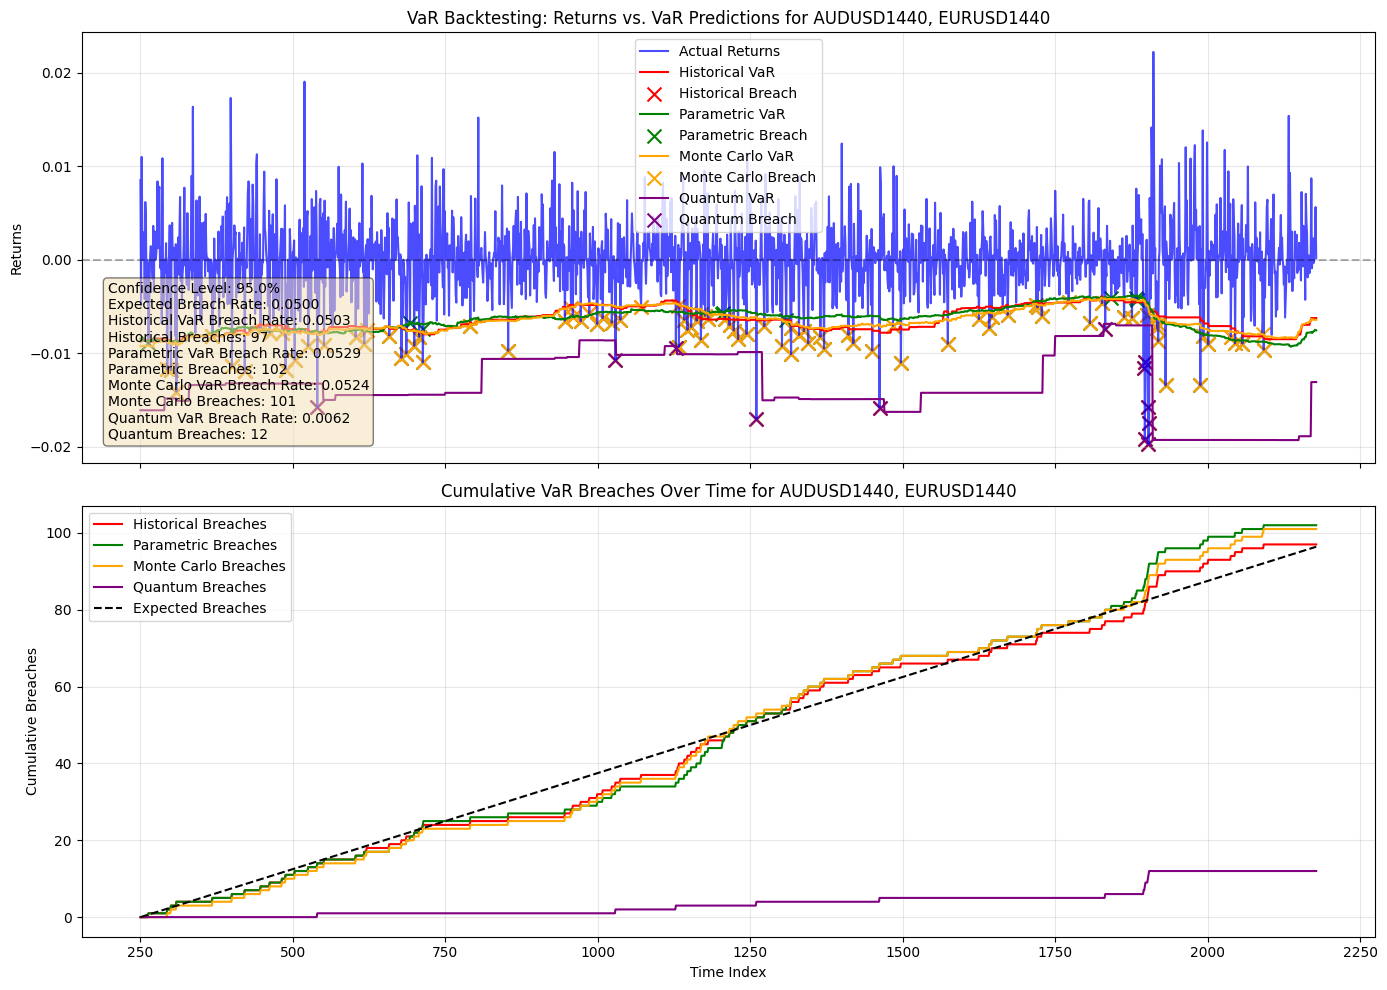

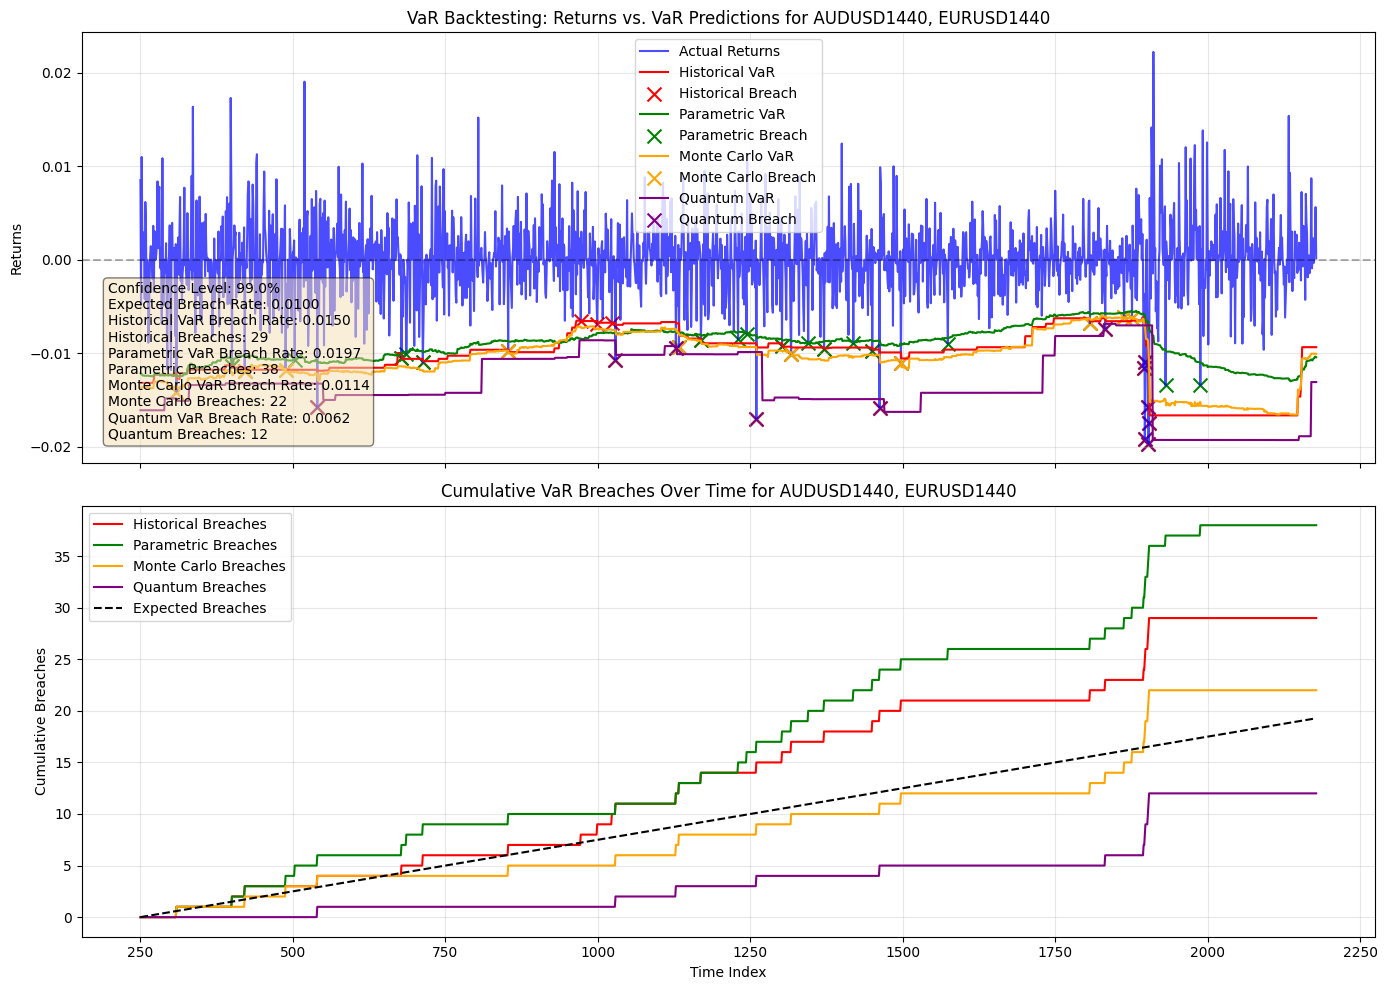

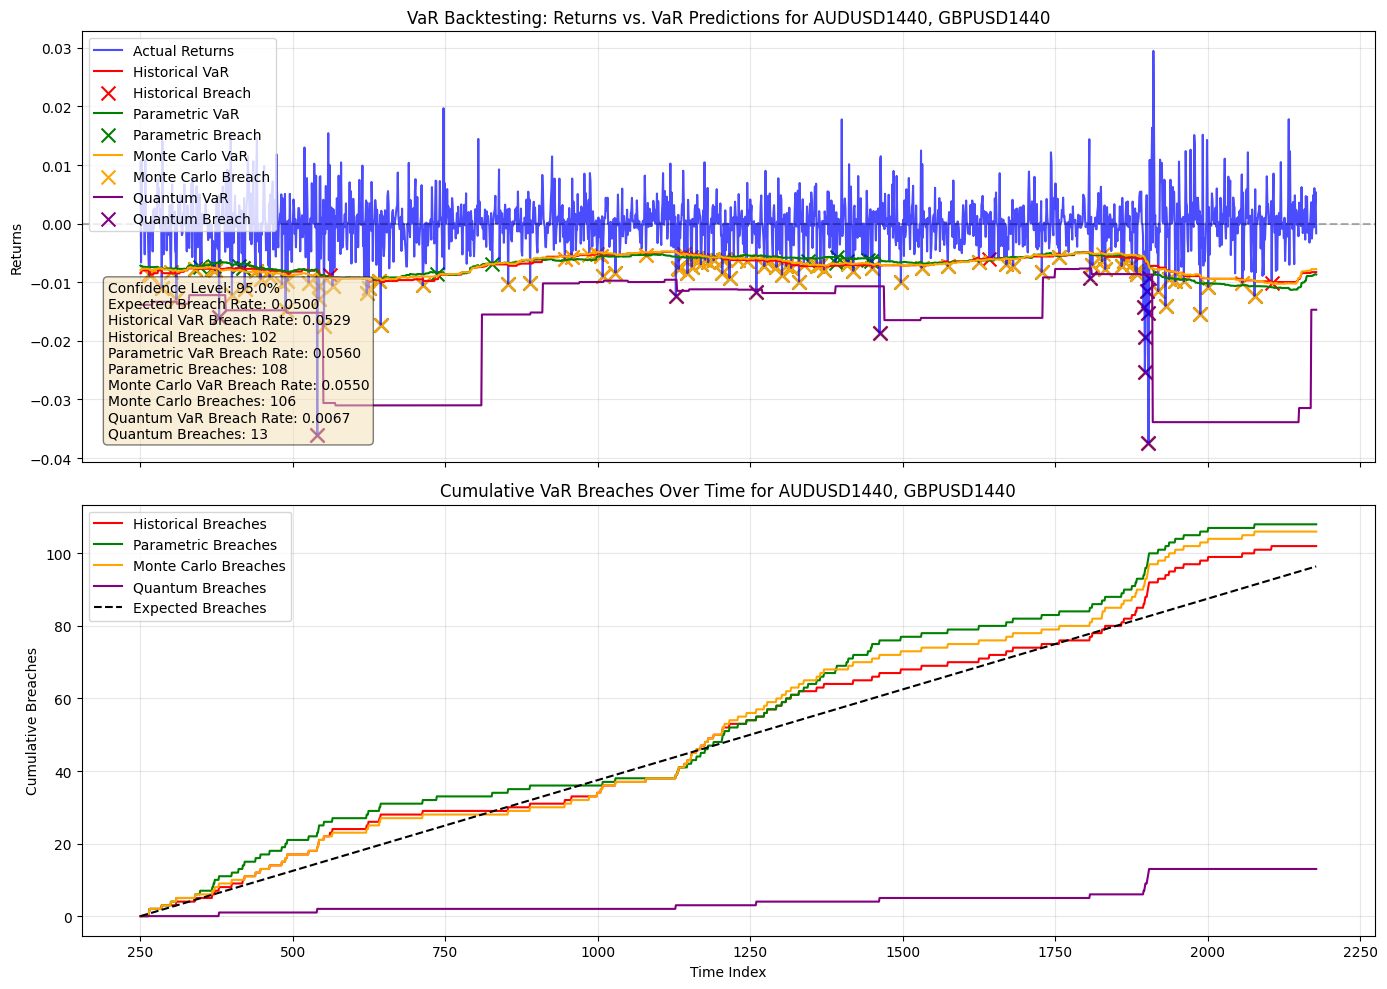

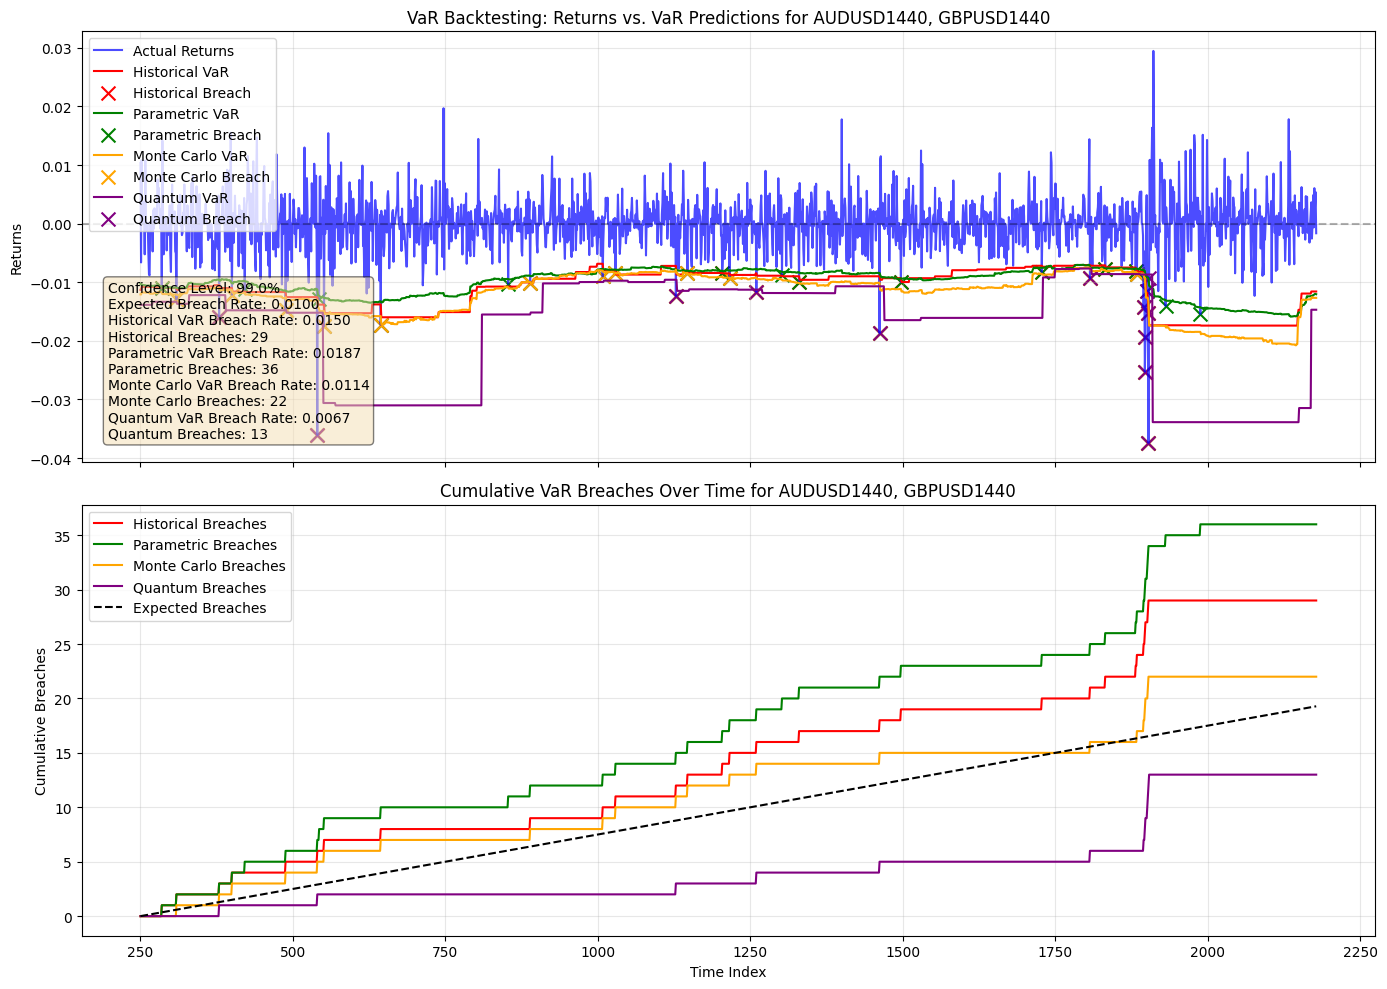

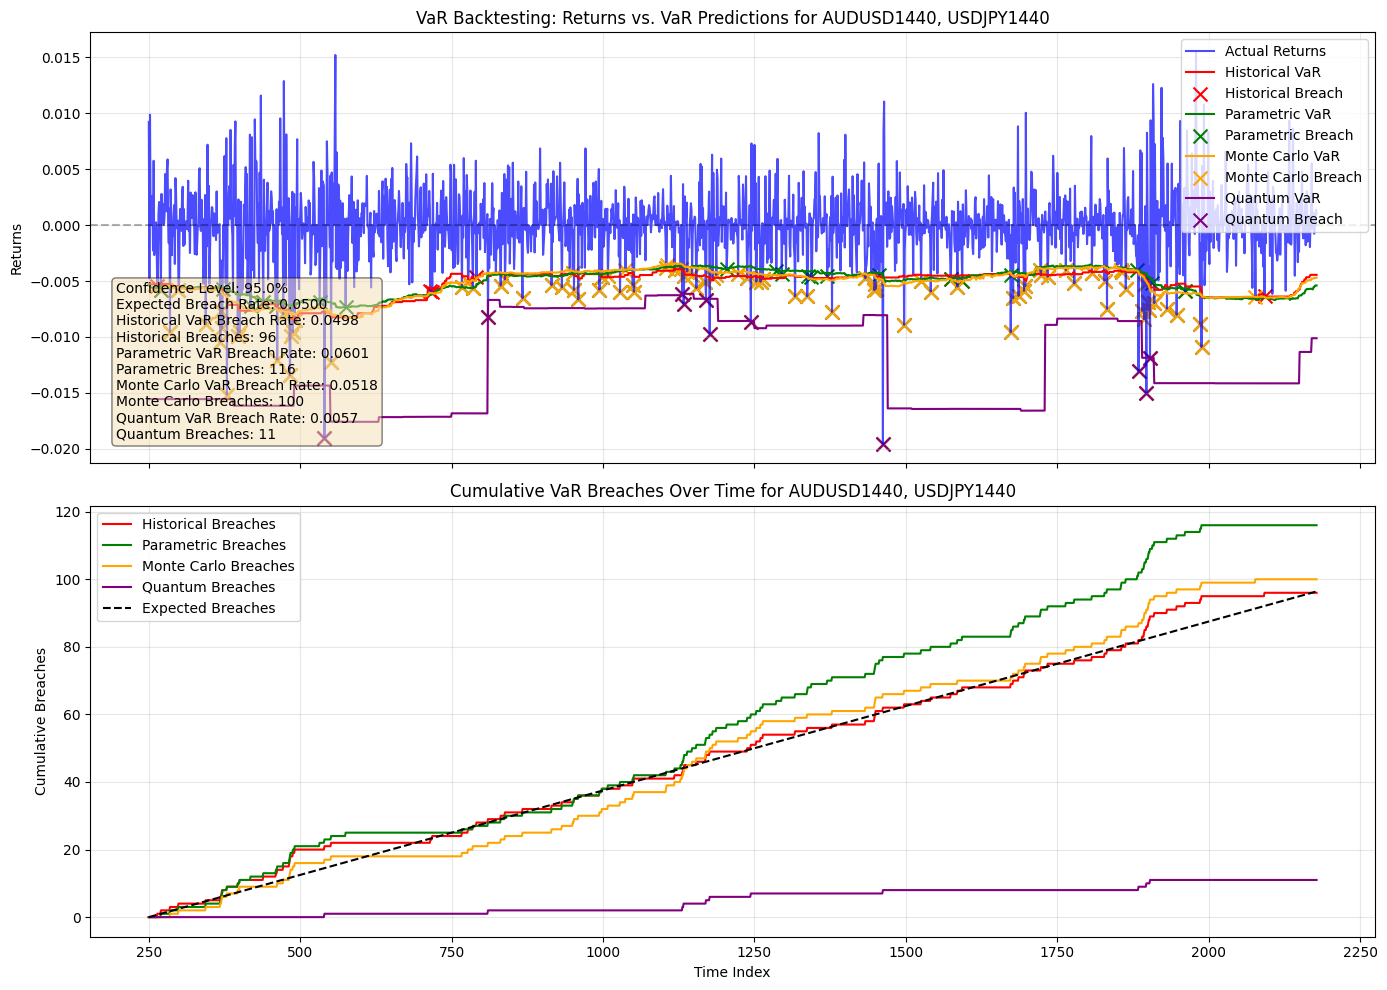

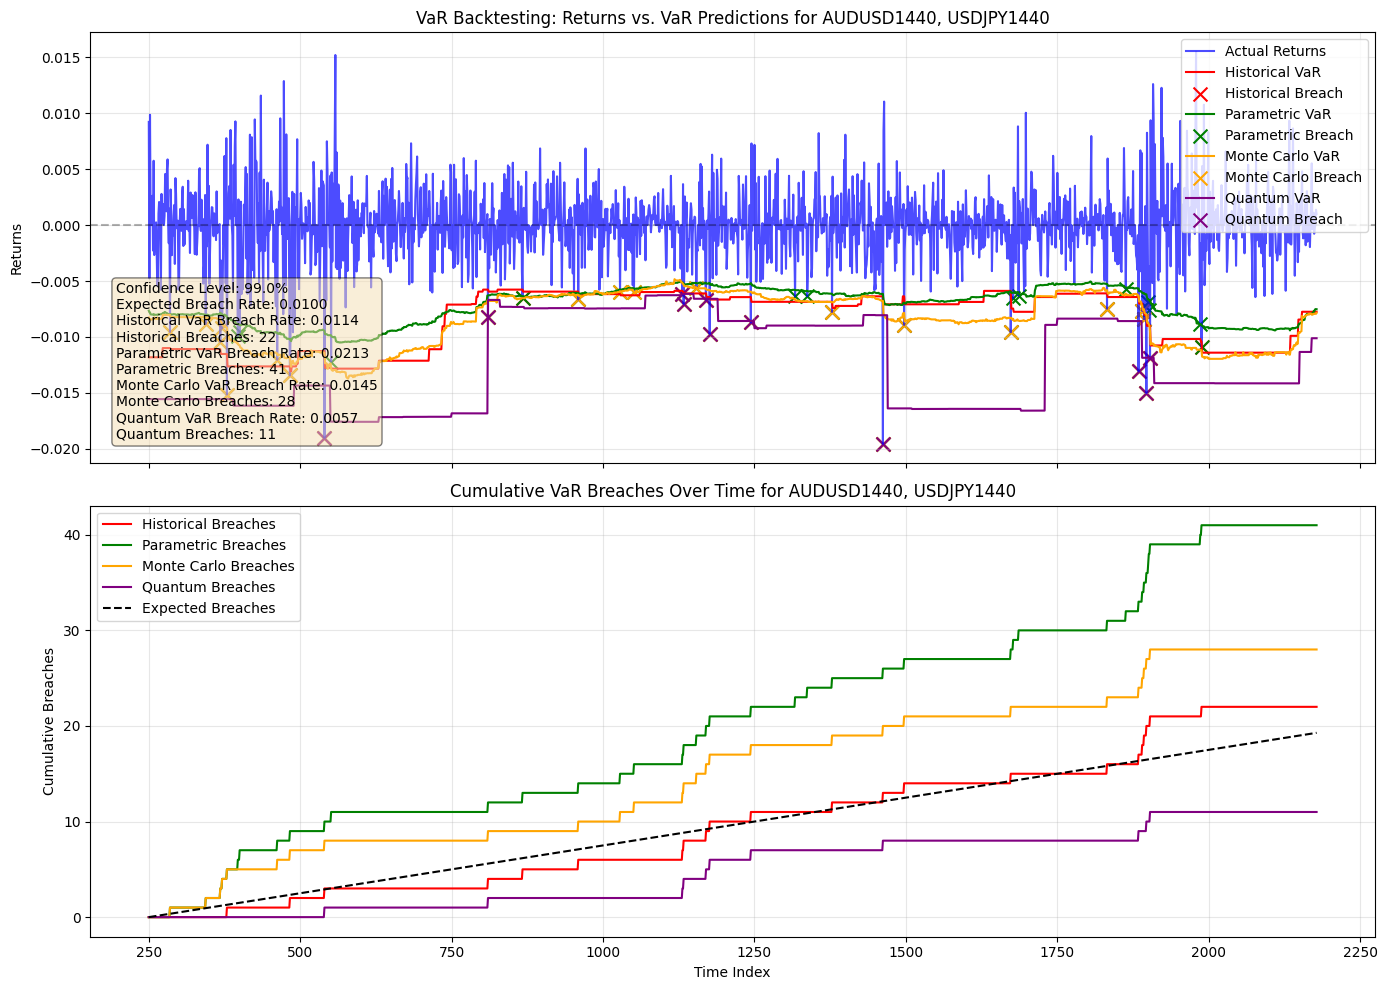

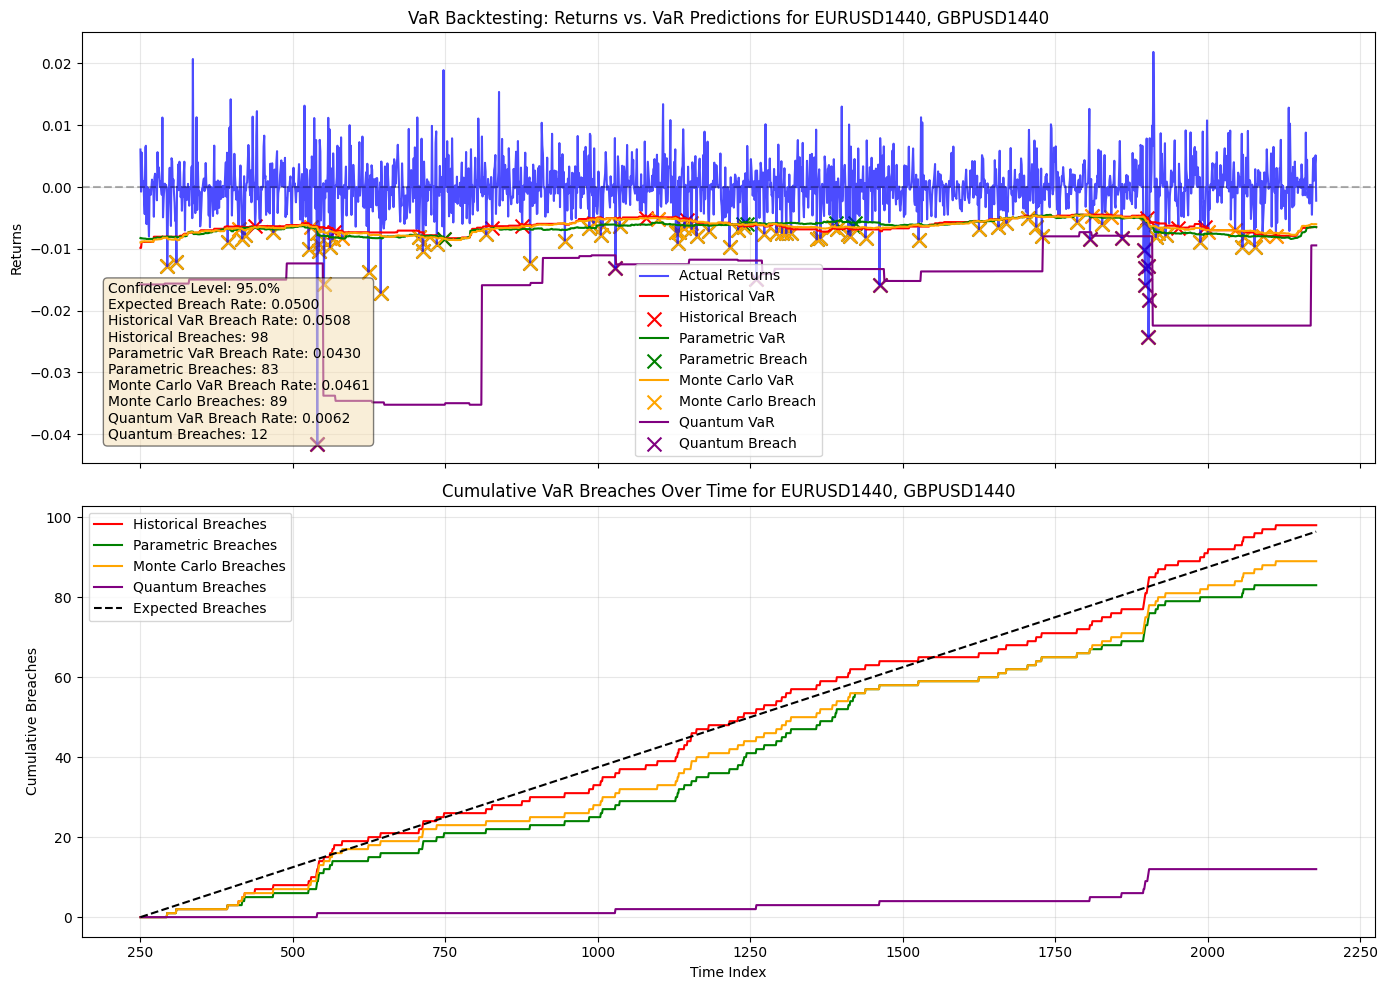

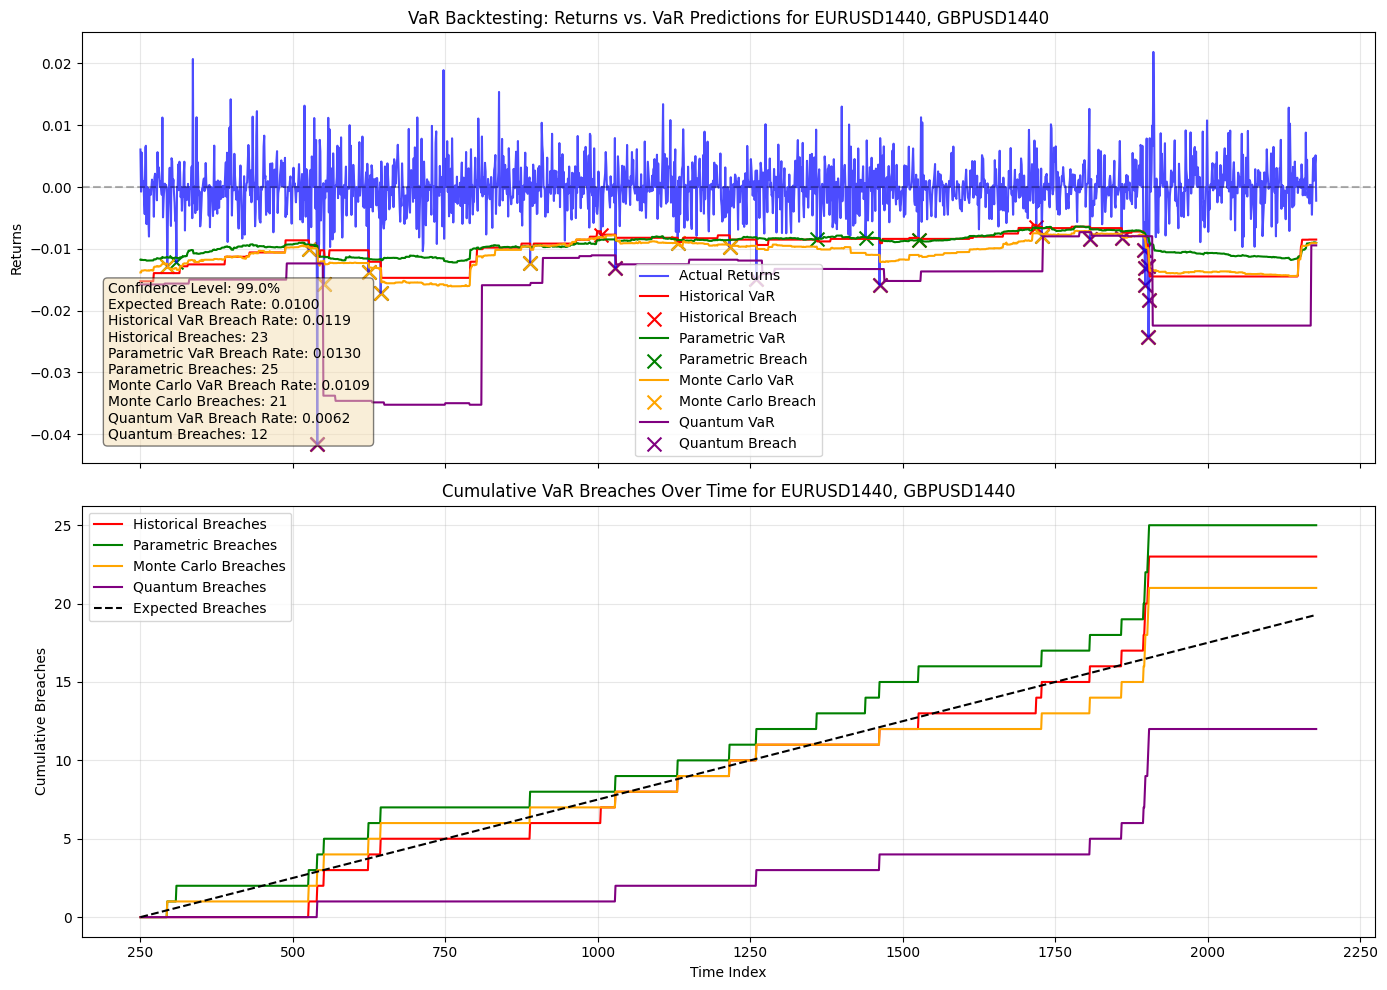

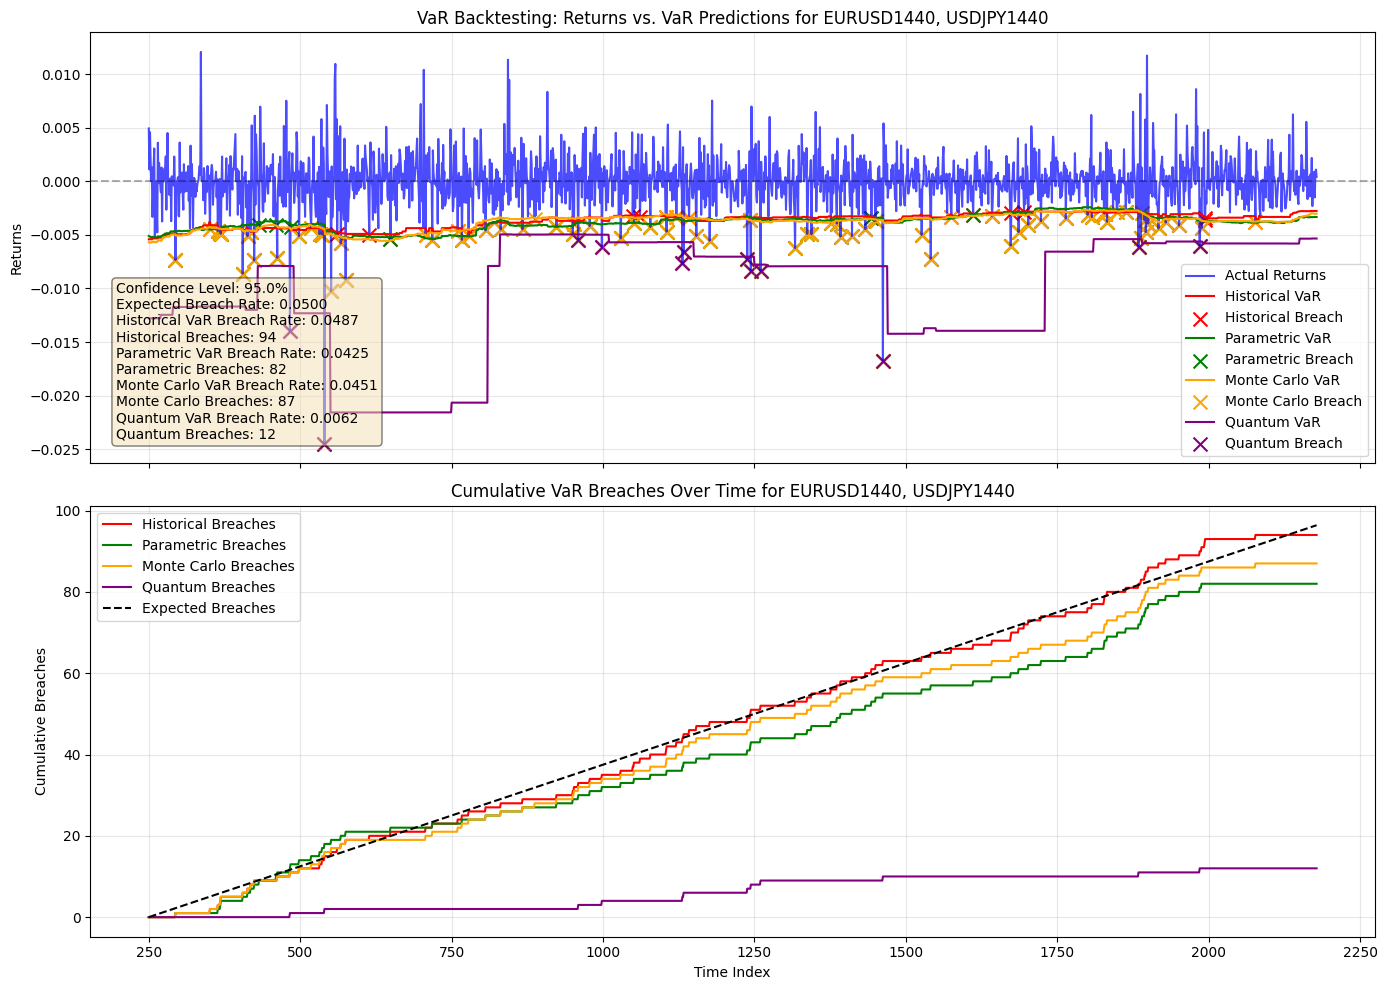

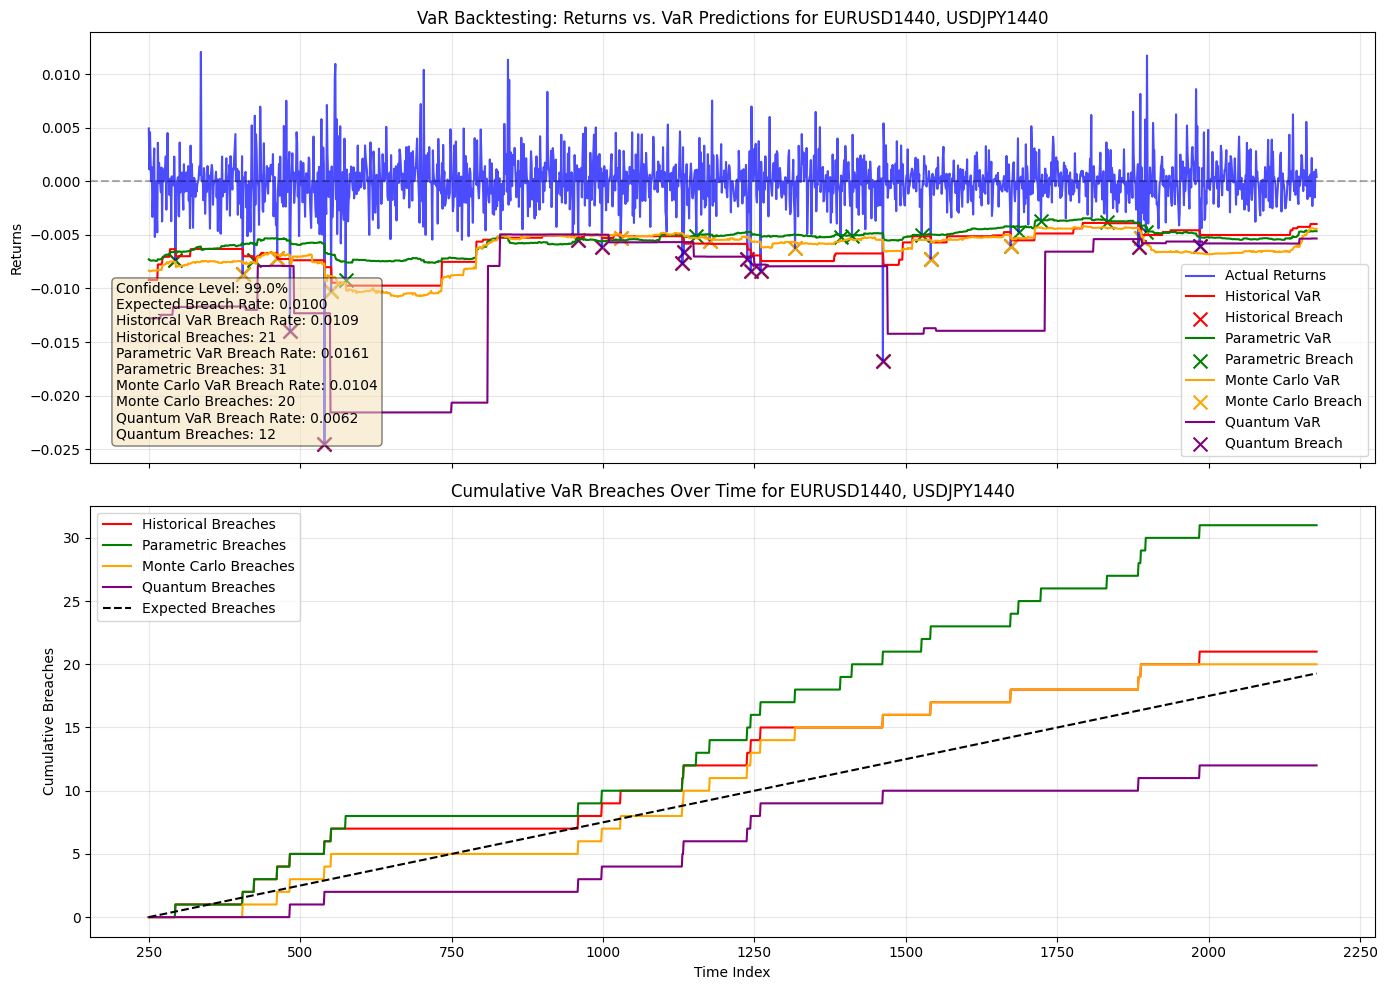

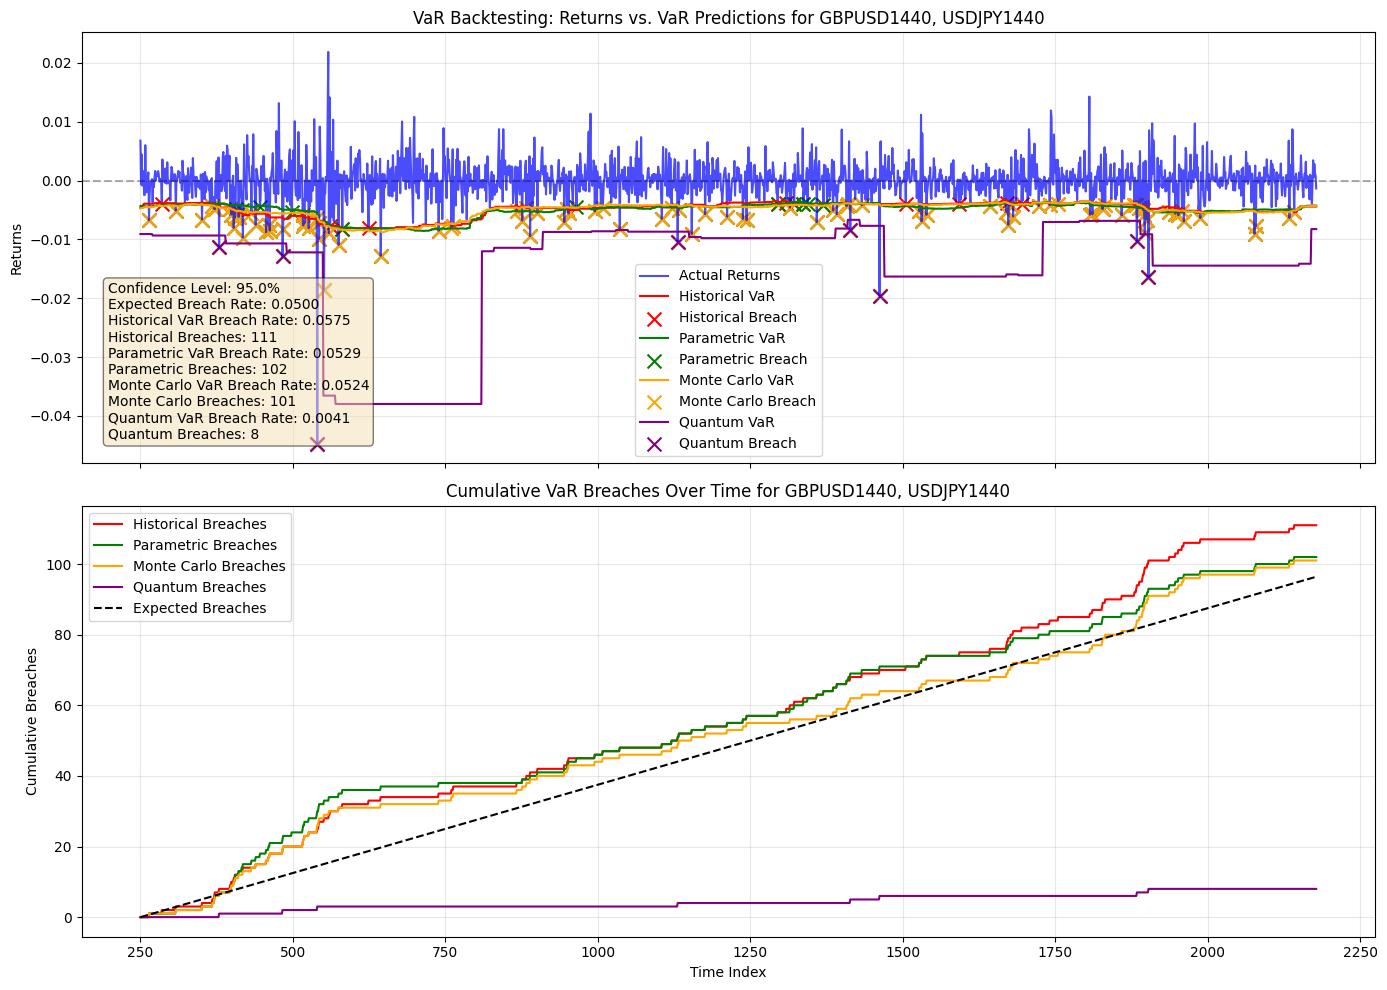

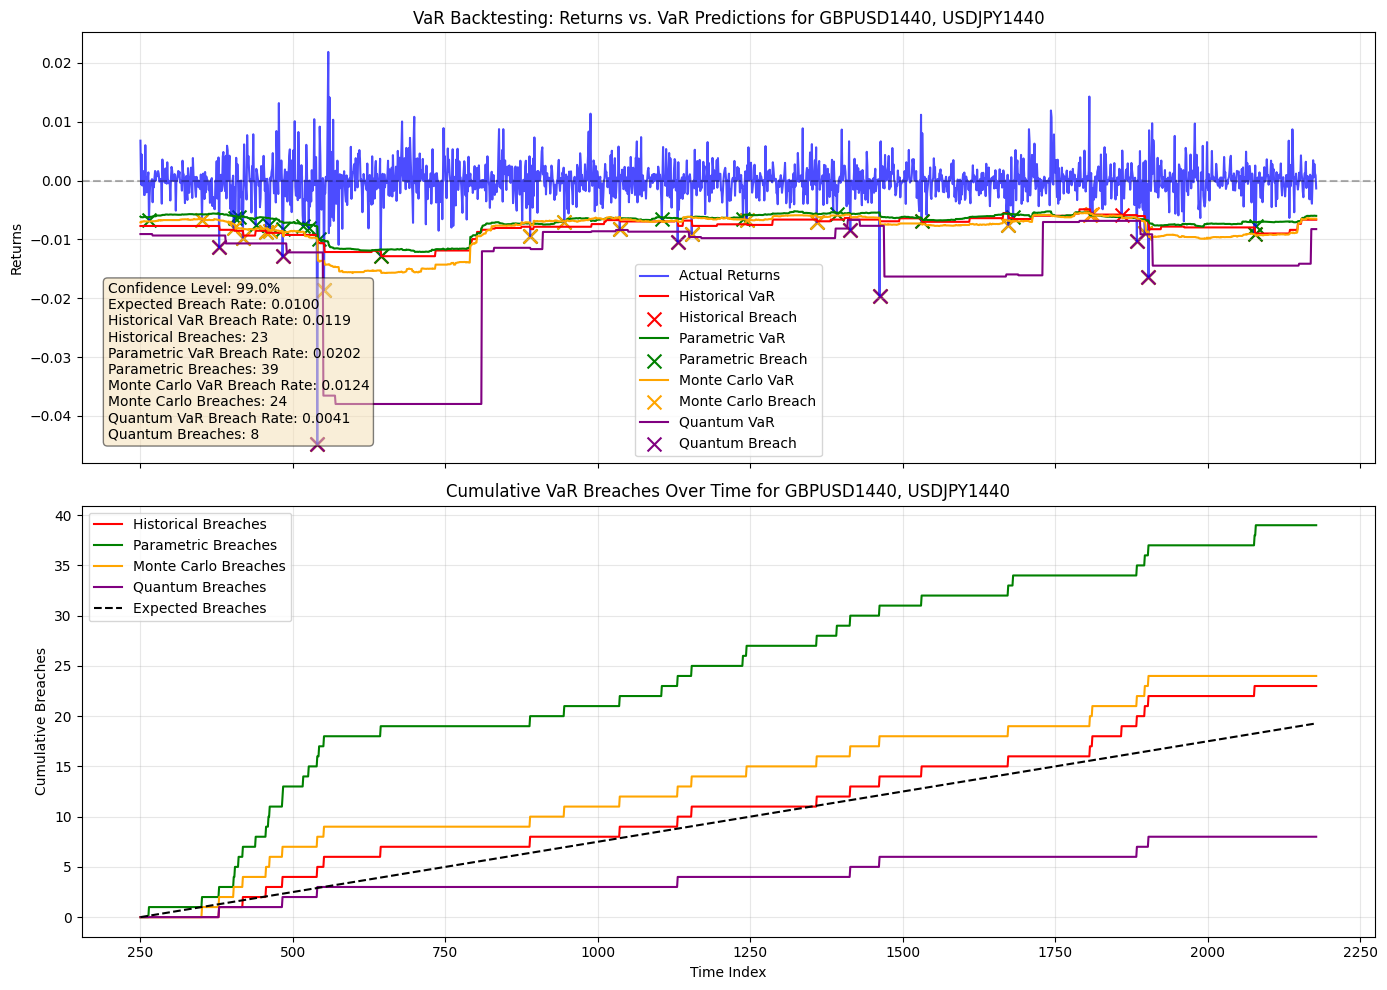

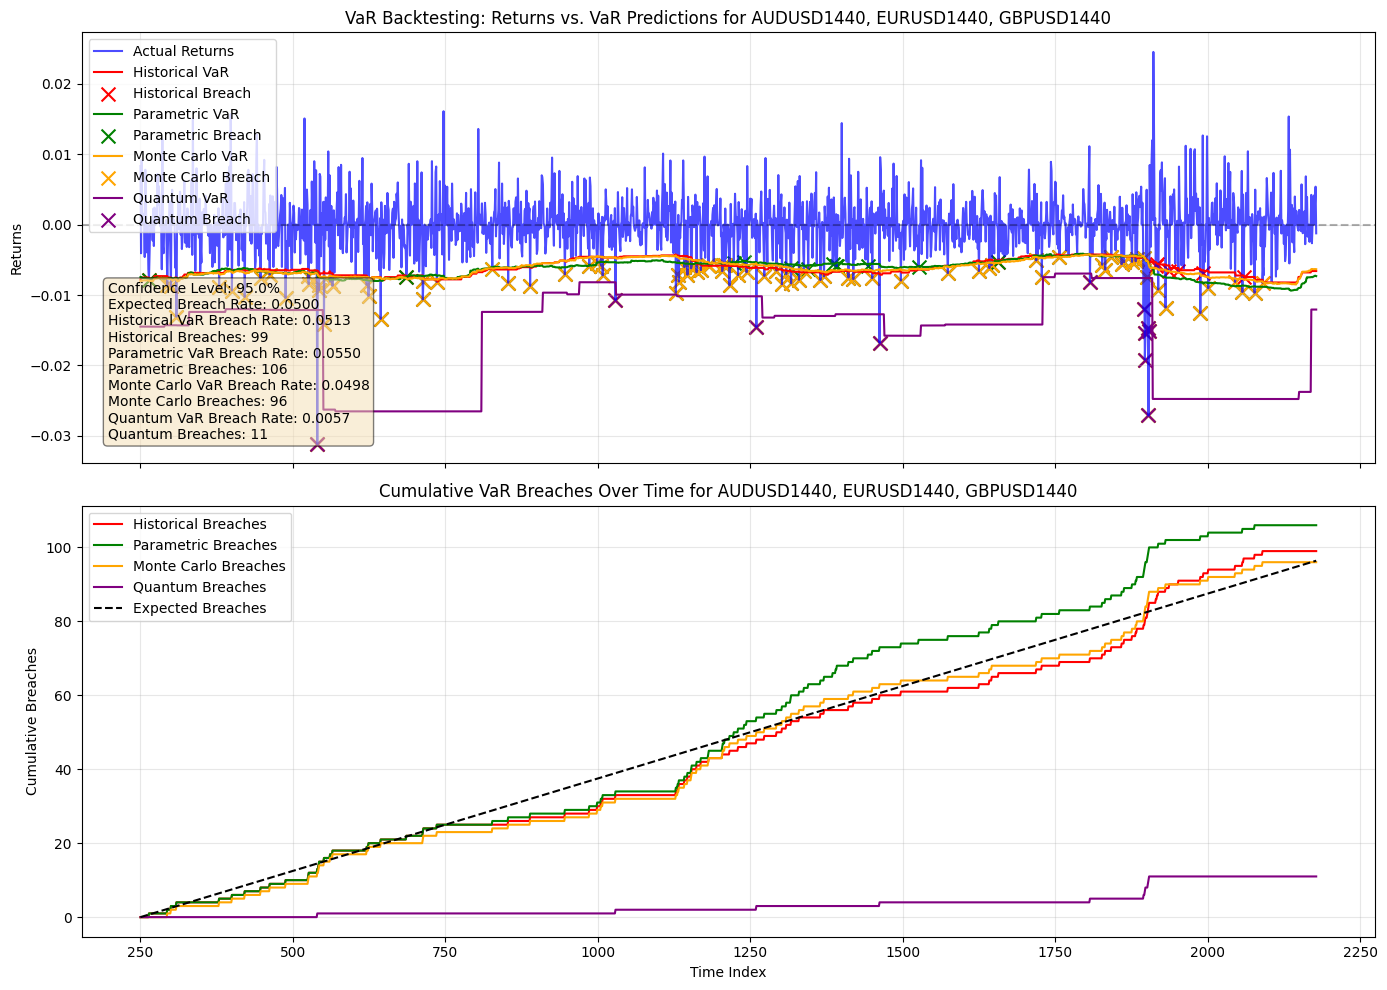

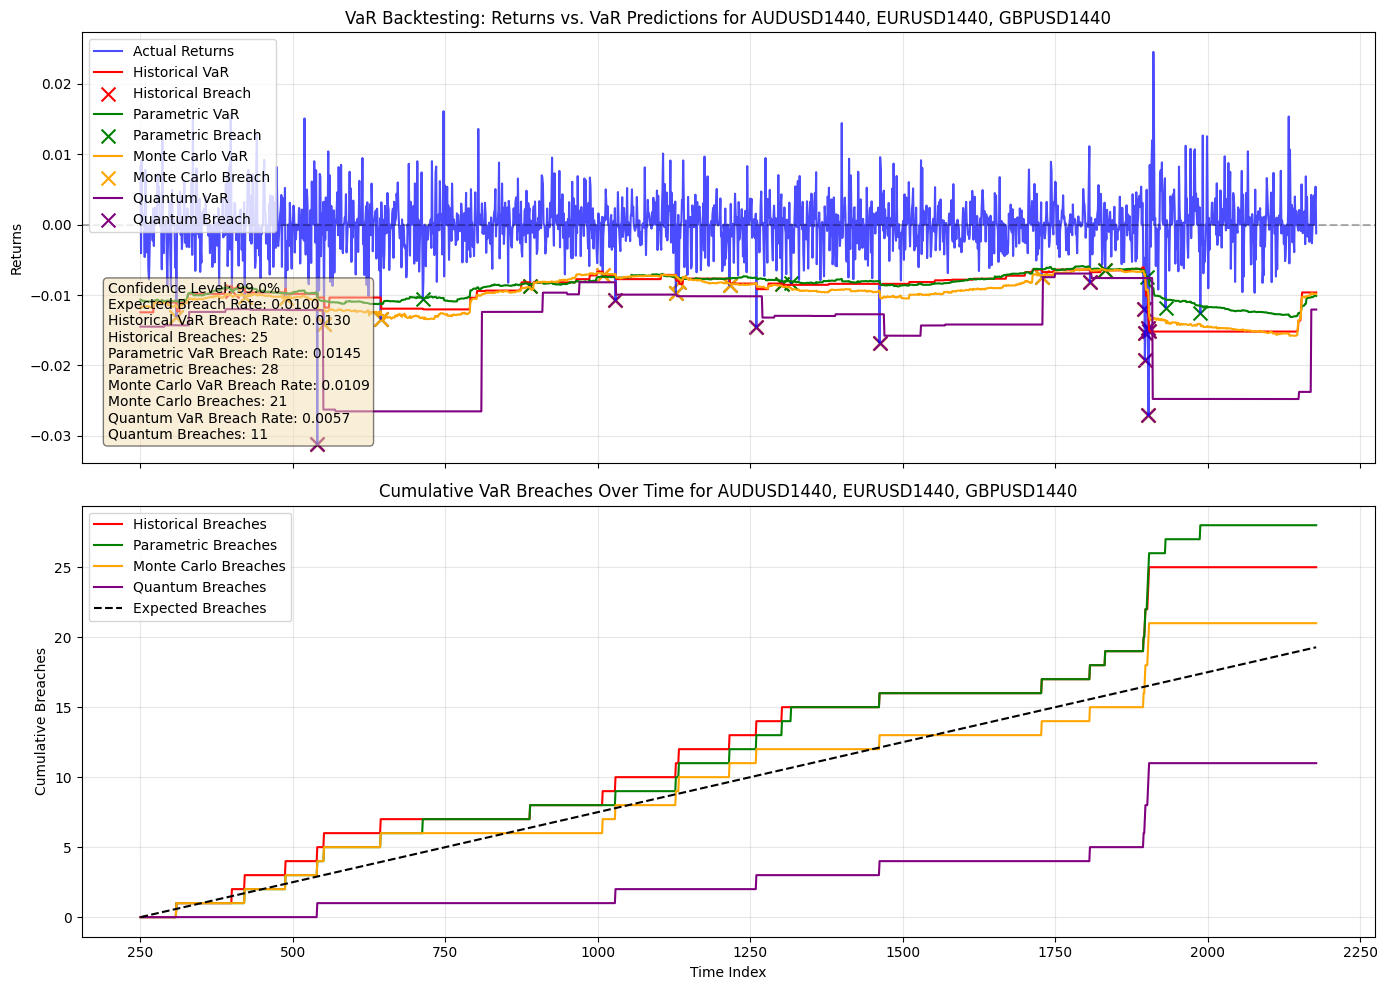

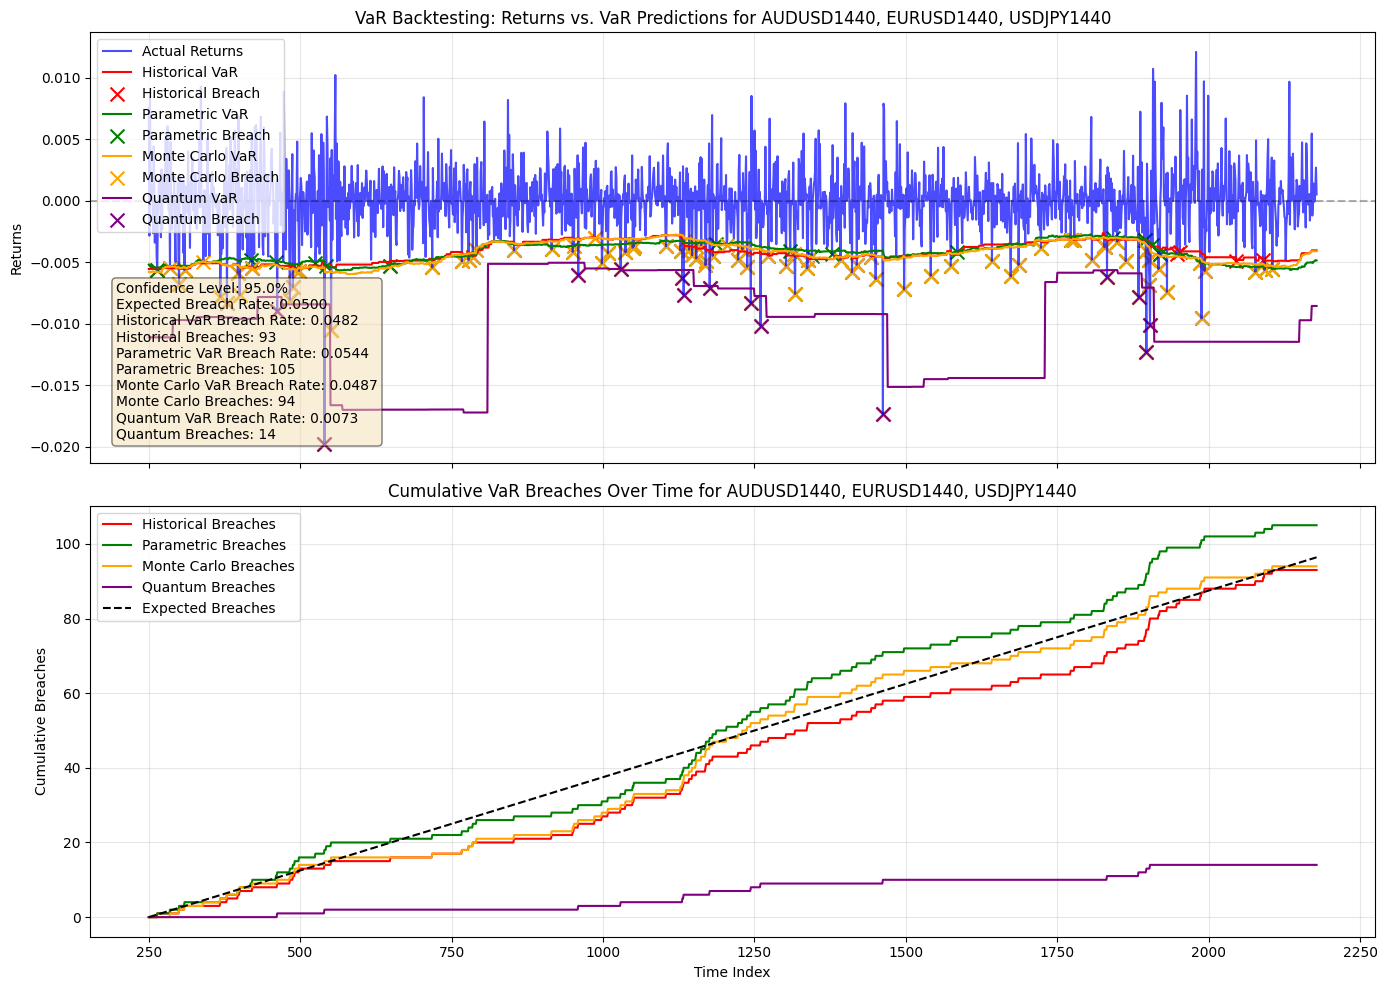

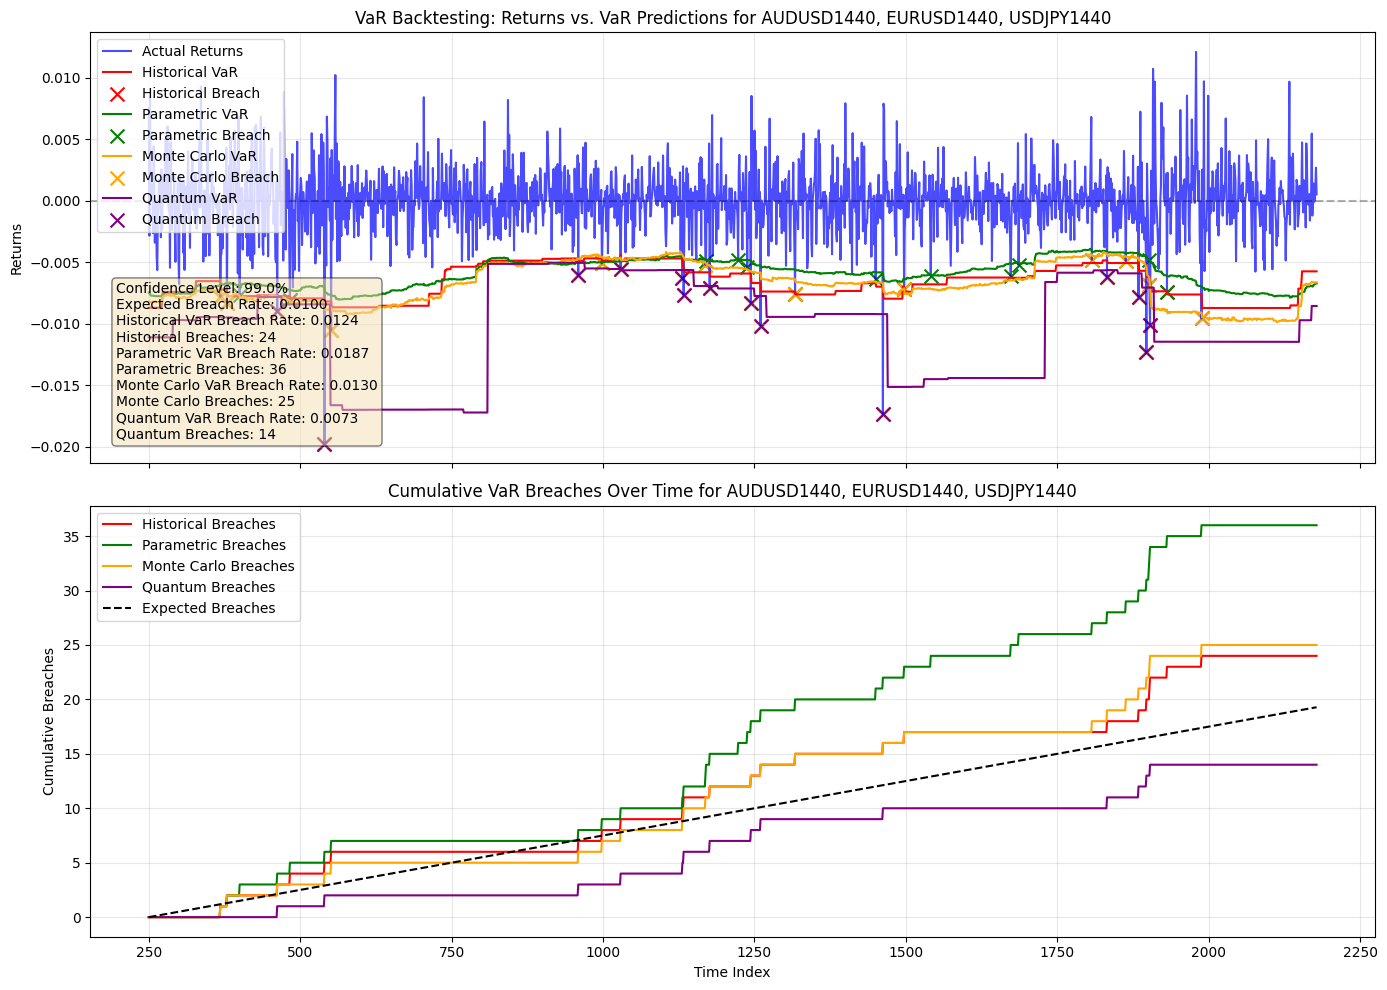

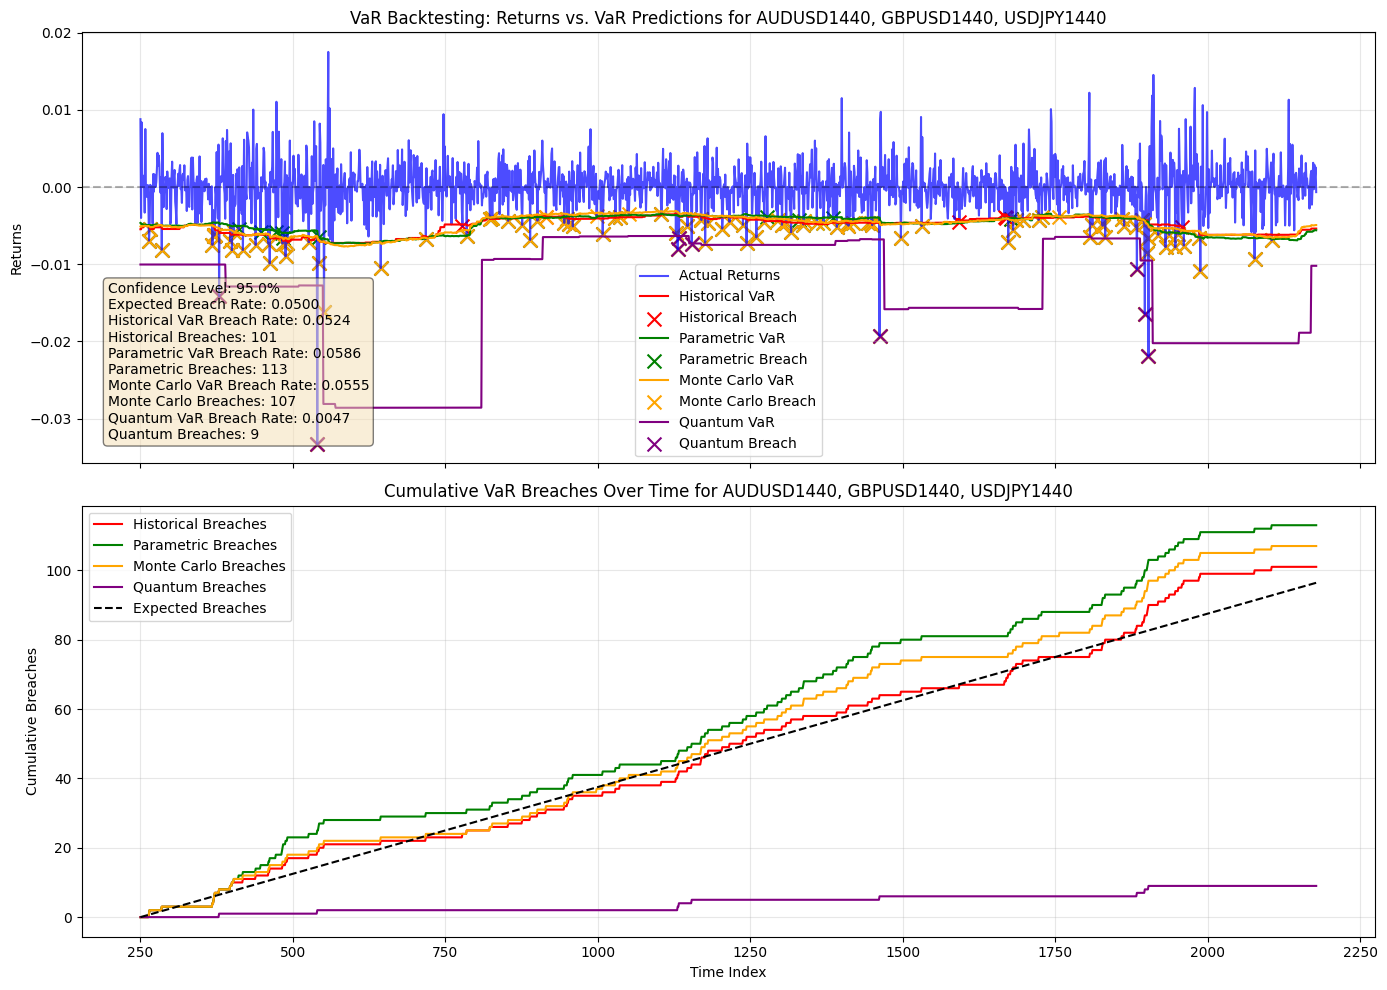

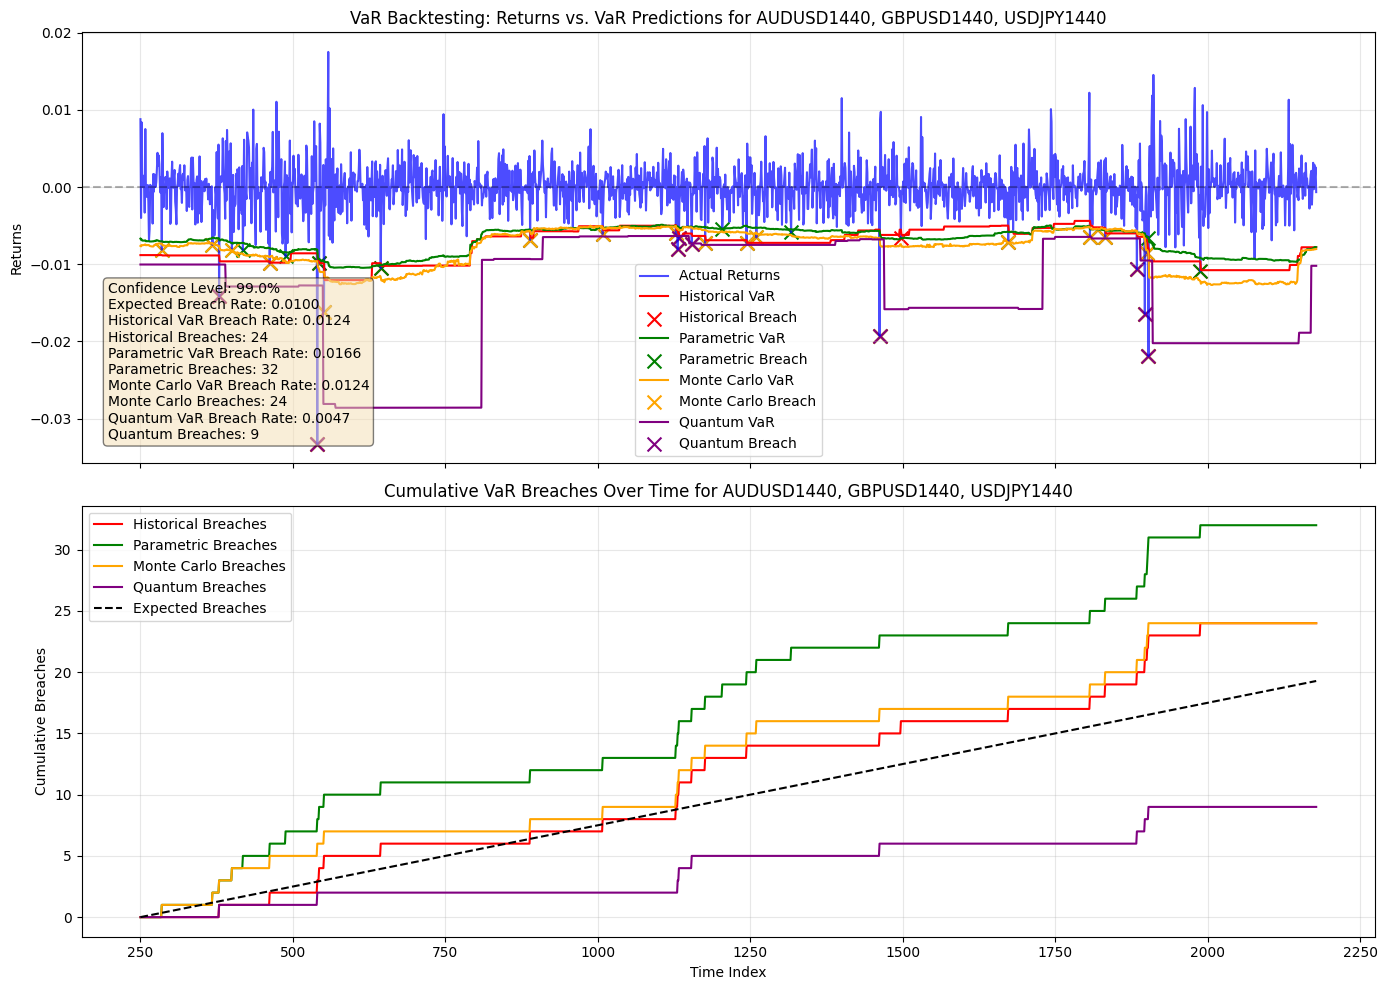

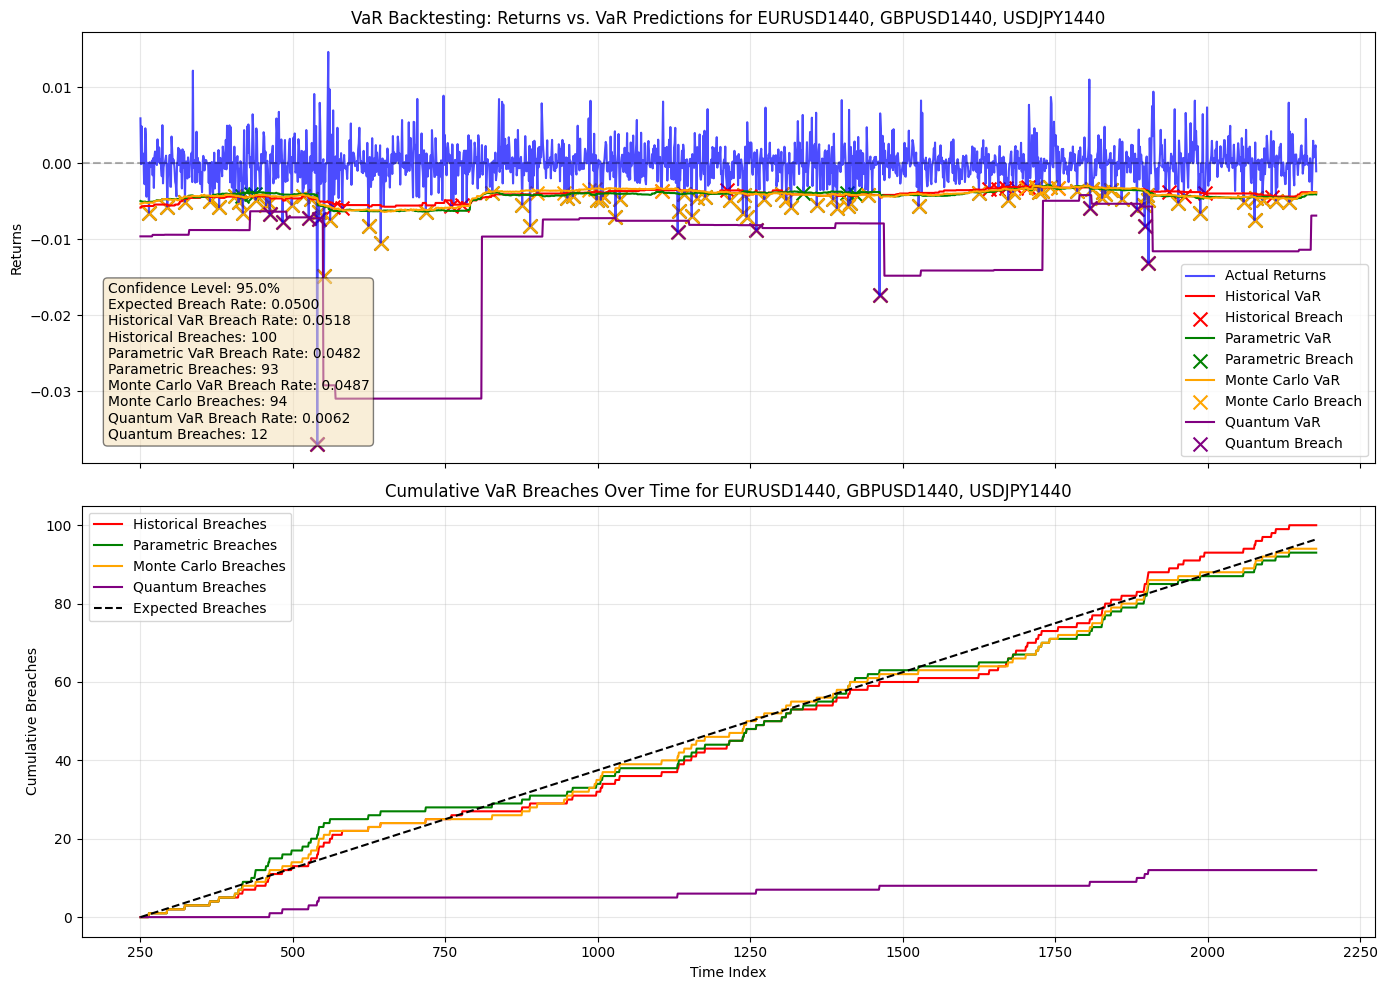

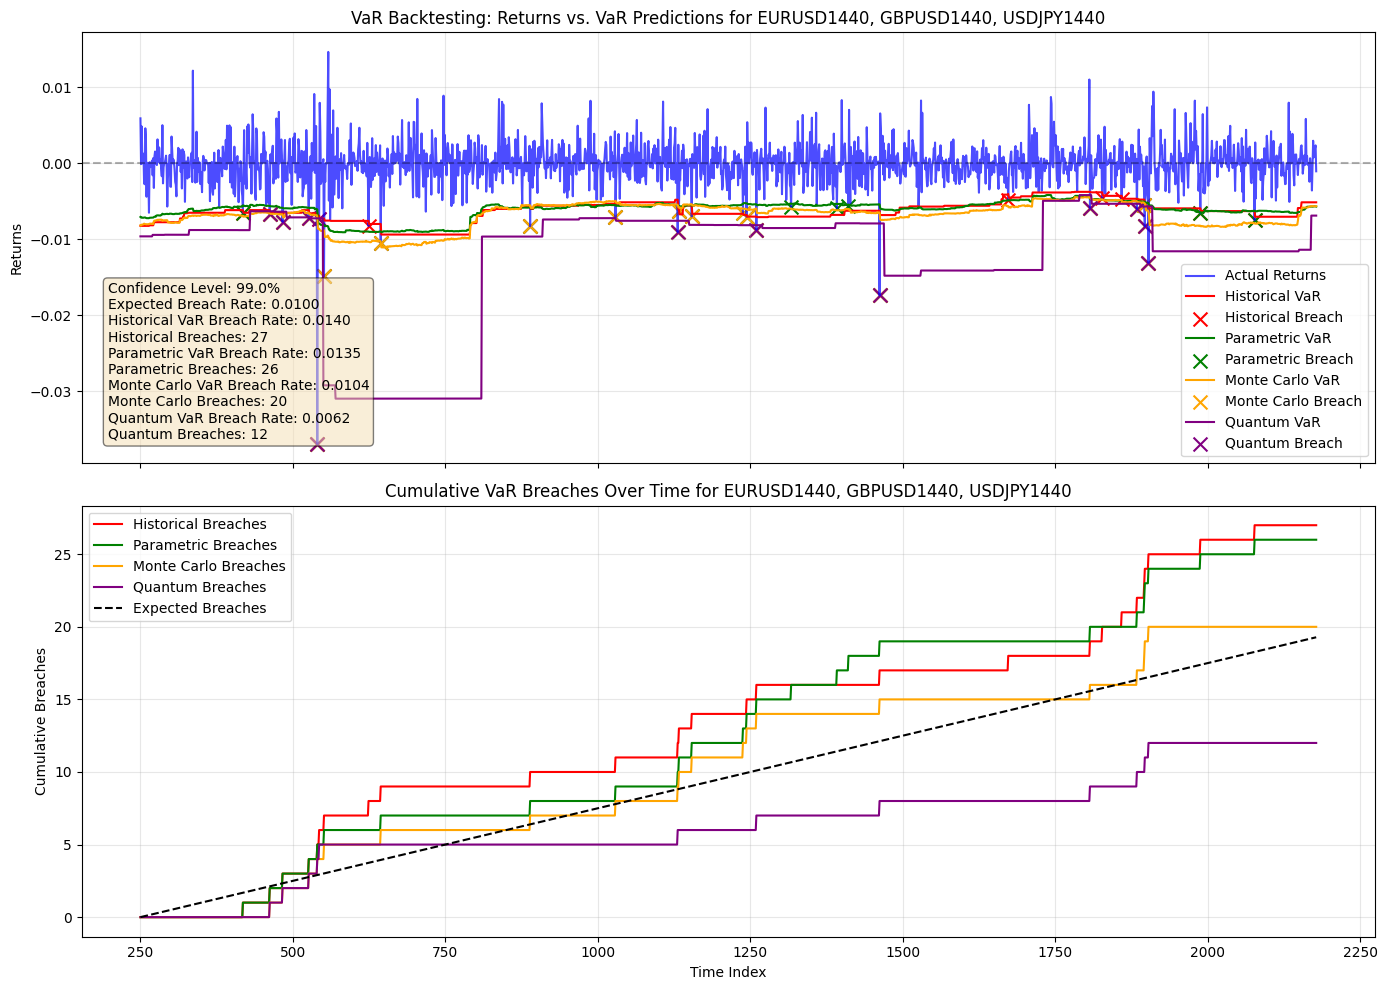

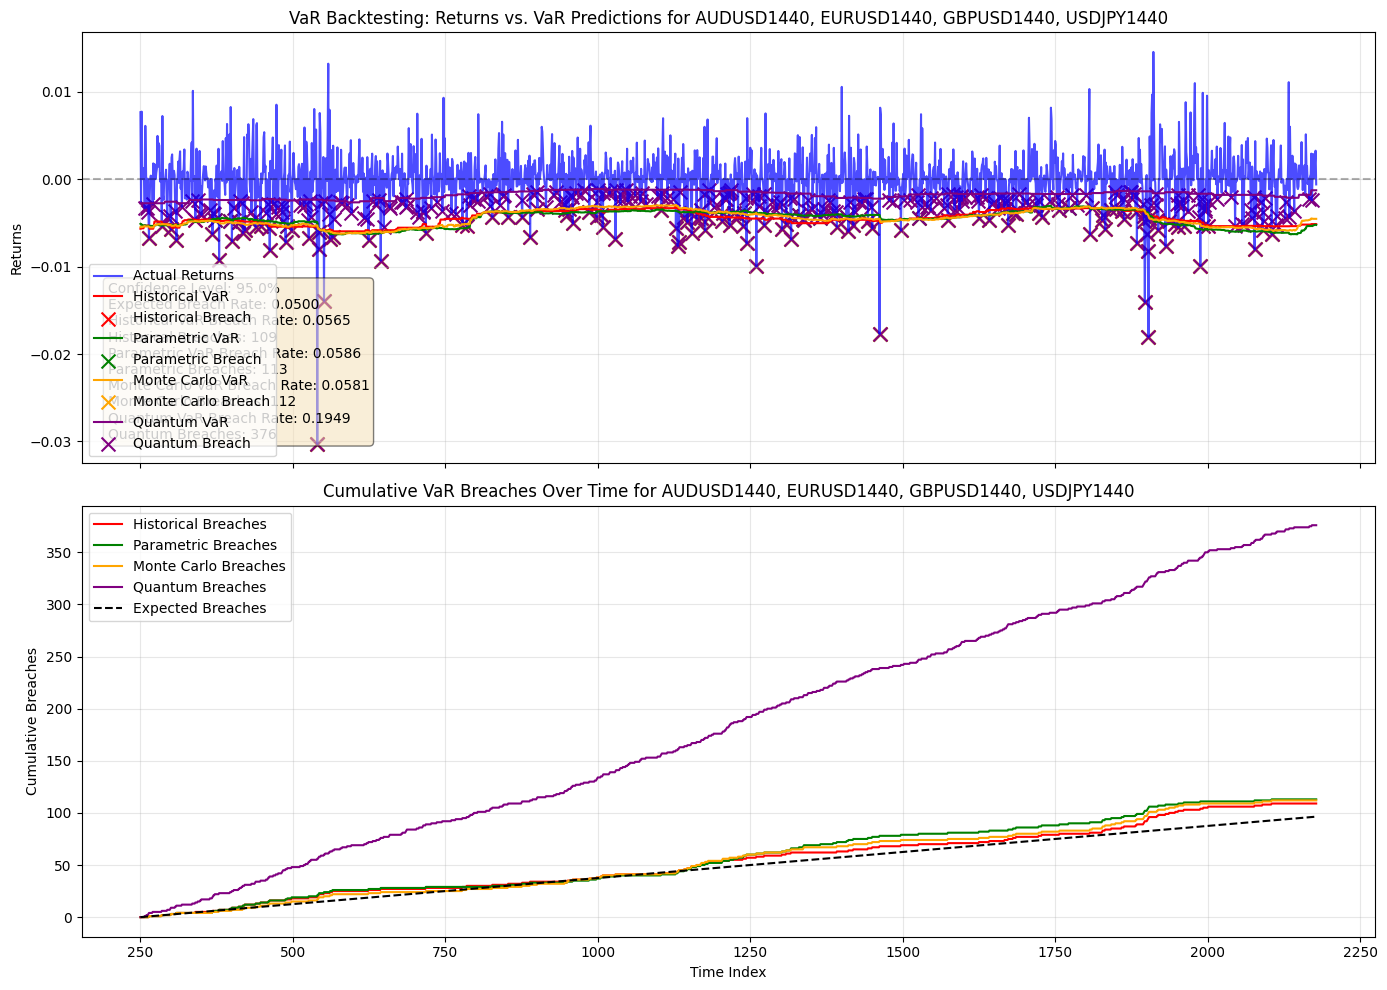

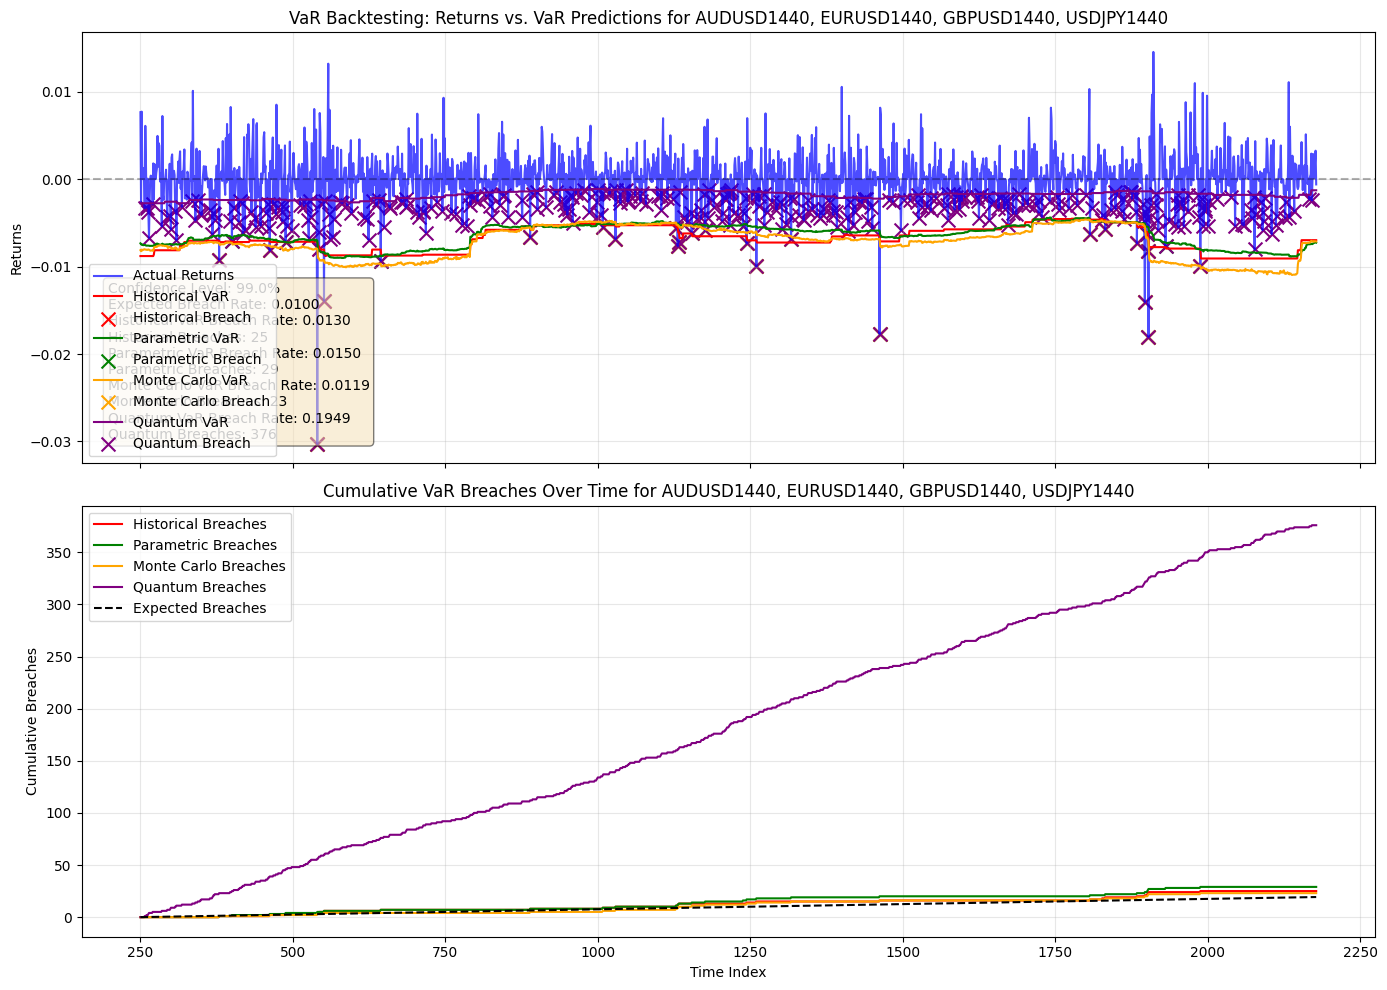

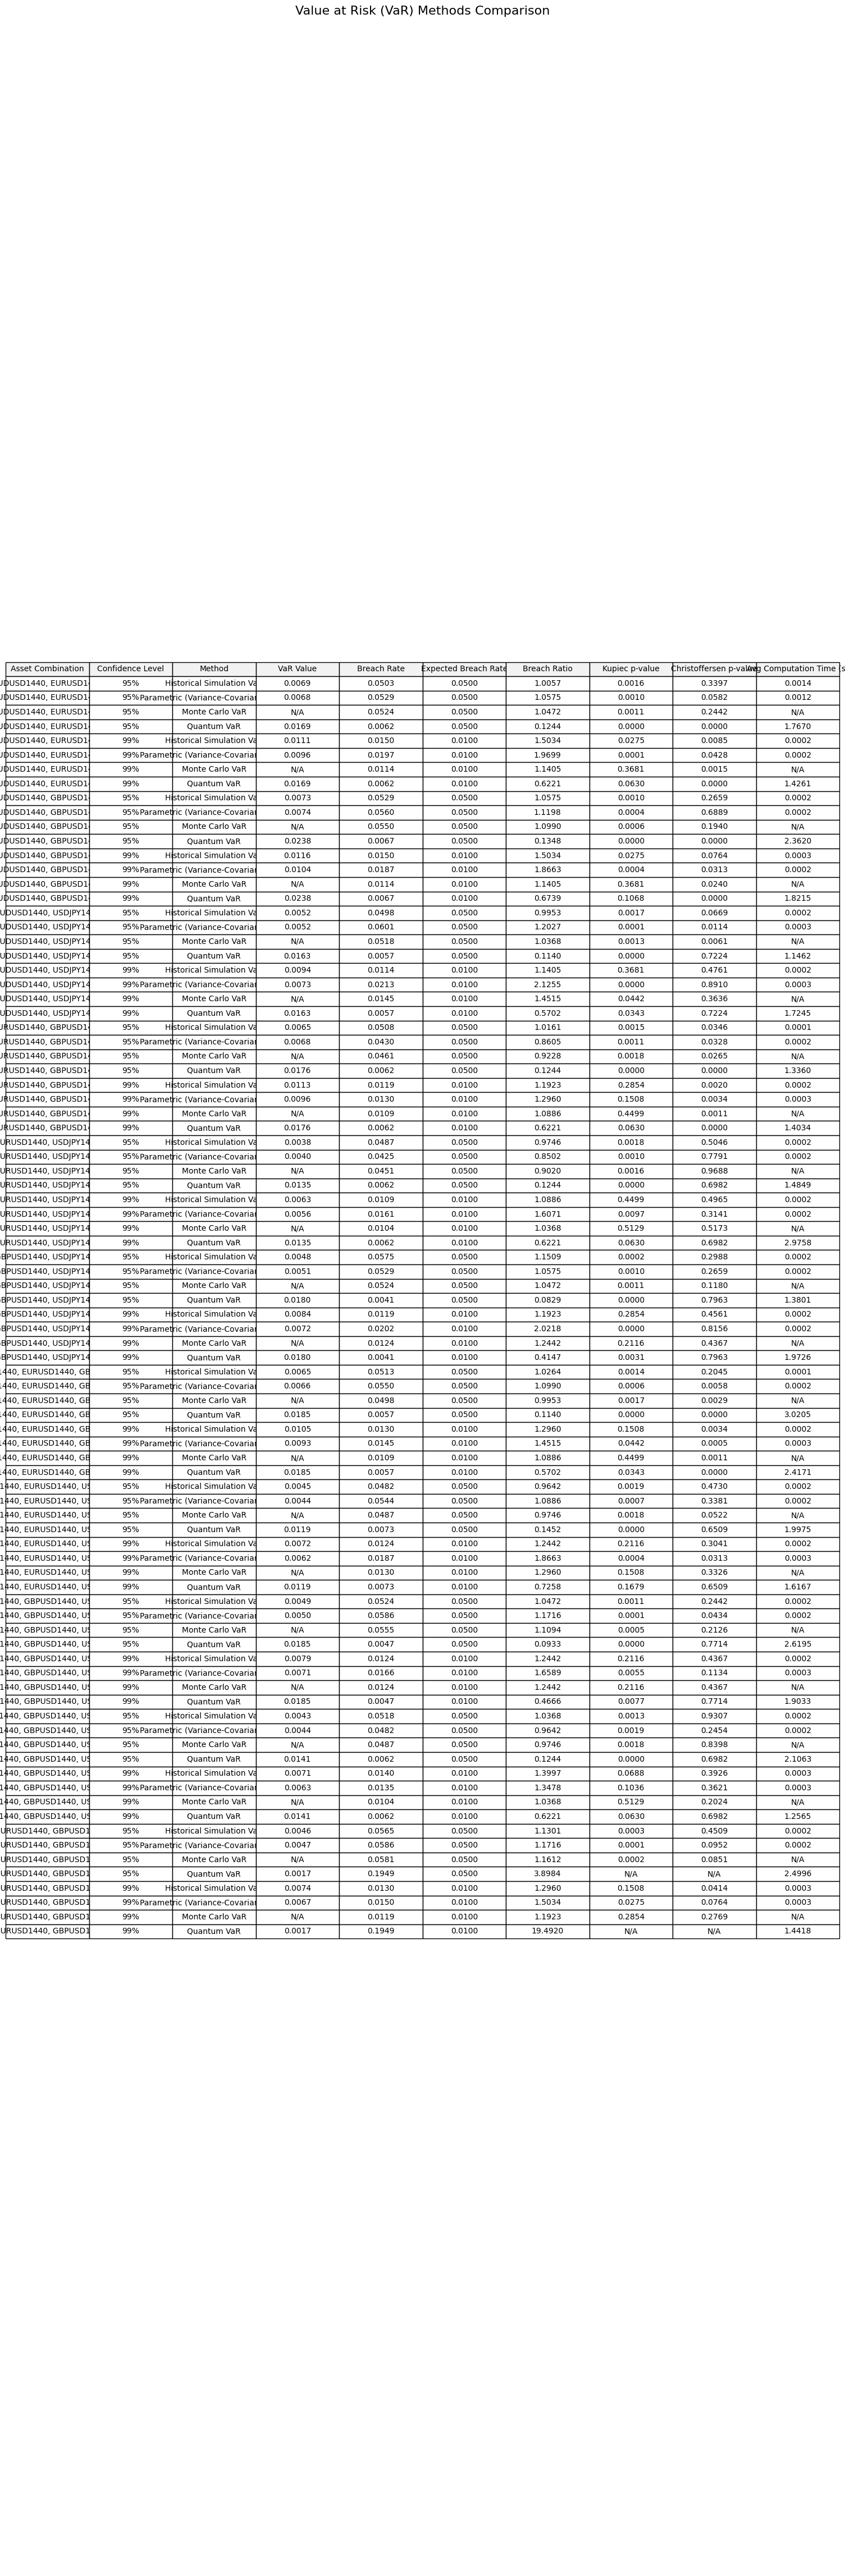

In [63]:
def main():

    # Define confidence levels to test
    confidence_levels = [0.95, 0.99]
    import warnings

    # Option 1: Filter this specific warning message
    warnings.filterwarnings("ignore", message="Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.")

    asset_paths = [
        "C:/Users/ahire/Downloads/mPhasis/data/AUDUSD1440.csv",
        "C:/Users/ahire/Downloads/mPhasis/data/EURUSD1440.csv",
        "C:/Users/ahire/Downloads/mPhasis/data/GBPUSD1440.csv",
        "C:/Users/ahire/Downloads/mPhasis/data/USDJPY1440.csv"  # Fourth asset
    ]
    # Run VaR analysis
    summary_df = run_var_analysis(asset_paths, confidence_levels)

    # Save summary DataFrame to CSV
    summary_df.to_csv('var_summary.csv', index=False)
    print("\nSaved summary DataFrame to 'var_summary.csv'")

    return summary_df

if __name__ == "__main__":
    main()